# Udacity Machine Learning Engineer Nanodegree
## Capstone Project:
## Predicting the Daily Stock directions in Turkish Stock Market

### Completed and Submitted by Görkem Göknar
### June 2018

DISCLAIMER REGARDING FORECAST AND PREDICTIONS:
Financial Results and coding work in this project are done for educational purposes only. Actual stock performance may differ from those predicted by this work. No guarantee is presented or implied as accuracy of forecasts contained. I am not responsible for any financial loss made using this report and code provided.



In [1]:
# Import libraries
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from capstone_module import *
from google_trend import *
import datetime

from IPython.display import display


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn')
sns.set()
%matplotlib inline 

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 850)

## LOAD DATA
Load data using web scraper
Below investing_api example is given but not used due to need for same timezone data
Investing gives foreign exchange rates by US close value, but since our target is Turkish market we need a local source. 

In [2]:
#international markets
#backup - will not use in this project
#put here for reference for whomever needs
import investing_api as inv
"""
166,S&P 500 , USA
17920,Bovespa, Brazil 
172,DAX, Germany   
40820,Shanghai, China
13666,MOEX, Russia
18, USD/TRY 
2103, USD/BRY 
2186, USD/RUB
3, USD/JPY
"""

"""
print("loading sp500")
sp500_df = inv.get_stock_from_as_df(166,"S&P 500", years=5)
sp500_df.rename(columns={'Price': 'Close'}, inplace=True)
sp500_df.drop(["Vol.", "Change %"],inplace=True,axis=1)
sp500_df["Date"]=pd.to_datetime(sp500_df["Date"])
print("Sp500 shape", sp500_df.shape)
"""

'\nprint("loading sp500")\nsp500_df = inv.get_stock_from_as_df(166,"S&P 500", years=5)\nsp500_df.rename(columns={\'Price\': \'Close\'}, inplace=True)\nsp500_df.drop(["Vol.", "Change %"],inplace=True,axis=1)\nsp500_df["Date"]=pd.to_datetime(sp500_df["Date"])\nprint("Sp500 shape", sp500_df.shape)\n'

Data is loaded from mynet.com using a custom web scraper. Drawback is we can not get the "Open" price , hence open price is ignored for all data. 

NOTE: ALL data for this Notebook is saved under data folder and can be replicated. 

In [4]:
##data is read from csv file before EDA


#Load BIST 30 Index - Last 5 years
#bist100_df_base = get_stock_from_mynet("XU100",stock_range="yillik_5",type="index")
bist30_df_base = get_stock_from_mynet("XU030",stock_range="yillik_5",type="index")
bist30_df_base.drop(["Stock"],inplace=True,axis=1)
bist30_df_base = bist30_df_base.sort_values(by='Date').reset_index(drop=True)
print("BIST30 shape", bist30_df_base.shape)
print("BIST30 Columns:\n",bist30_df_base.columns)

http://finans.mynet.com/borsa/ajaxCharts/?type=index&ticker=XU030&range=5y
Stock: BIST 30
BIST30 shape (1239, 5)
BIST30 Columns:
 Index(['Date', 'High', 'Low', 'Volume', 'Close'], dtype='object')


For the base performance test "AKBNK" stock (Akbank - one of the big Turkish banks, that is on BIST 30 index) is used.
At the bottom of the notebook, other stocks are also tested for simulation.

In [5]:
##Data is read from csv file before EDA

#Load stock data

#Target stock will be selected when merging data
#Target 1 - Akbank - Local Bank
akbnk_df_base = get_stock_from_mynet("AKBNK",stock_range="yillik_5") #-24,03% in year
#print("AKBNK Columns:\n",akbnk_df_base.columns)

#Target 2 - THYAO - Turkish Airlines - global
#thyao_df_base = get_stock_from_mynet("THYAO",stock_range="yillik_5") #69,66% in year
#ttrak_df_base = get_stock_from_mynet("TTRAK",stock_range="yillik_5") #-32,70% in year

#Target 3 - TUPRS - Tüpraş - Responsible for oil price in Turkey
#tuprs_df_base = get_stock_from_mynet("TUPRS",stock_range="yillik_5")

#Telekom - Turkcell
#tcell_df_base = get_stock_from_mynet("TCELL",stock_range="yillik_5") # 11.08% in year

#Telekom - Alcatel (now Nokia)
#alctl_df_base = get_stock_from_mynet("ALCTL",stock_range="yillik_5") #-52,91% in year

#Automotive
#asuzu_df_base = get_stock_from_mynet("ASUZU",stock_range="yillik_5") #-52,91% in year
#toaso_df = get_stock_from_mynet("TOASO",stock_range="yillik_5")


#Foreign Exchange rates
usdtry_df_base= get_exchange_from_mynet("USD",exchange_range="yillik_5")
print("USD/TRY Columns:\n",usdtry_df_base.columns)

#eurtry_df= get_exchange_from_mynet("EUR")
#gbptry_df= get_exchange_from_mynet("GBP")
#cnytry_df= get_exchange_from_mynet("CNY")
#bhdtry_df= get_exchange_from_mynet("BHD")

#Russian Ruble 
rubtry_df_base= get_exchange_from_mynet("RUB",exchange_range="yillik_5")

#Brazil Real
brltry_df_base= get_exchange_from_mynet("BRL",exchange_range="yillik_5")

#Japanese Yen
jpytry_df_base= get_exchange_from_mynet("JPY",exchange_range="yillik_5")



http://finans.mynet.com/borsa/ajaxCharts/?type=stock&ticker=AKBNK&range=5y
Stock: AKBNK
http://finans.mynet.com/doviz/ajaxCharts/?doviz=USD&market=freeMarket&period=5y
Stock: USD
USD/TRY Columns:
 Index(['Exchange', 'Date', 'High', 'Low', 'Close'], dtype='object')
http://finans.mynet.com/doviz/ajaxCharts/?doviz=RUB&market=freeMarket&period=5y
Stock: RUB
http://finans.mynet.com/doviz/ajaxCharts/?doviz=BRL&market=freeMarket&period=5y
Stock: BRL
http://finans.mynet.com/doviz/ajaxCharts/?doviz=JPY&market=freeMarket&period=5y
Stock: JPY


In [73]:
###USE Following to replicate notebook results
#load data from csv
"""
""" 
bist30_df_base = pd.read_csv('data/bist30_df_base.csv').drop("Unnamed: 0",axis=1)
print("BIST30 shape", bist30_df_base.shape)
print("BIST30 Columns:\n",bist30_df_base.columns)

akbnk_df_base = pd.read_csv('data/akbnk_df_base.csv').drop("Unnamed: 0",axis=1)
print("AKBNK shape", akbnk_df_base.shape)
print("AKBNK Columns:\n",akbnk_df_base.columns)


usdtry_df_base = pd.read_csv('data/usdtry_df_base.csv').drop("Unnamed: 0",axis=1)
rubtry_df_base = pd.read_csv('data/rubtry_df_base.csv').drop("Unnamed: 0",axis=1)
brltry_df_base = pd.read_csv('data/brltry_df_base.csv').drop("Unnamed: 0",axis=1)
jpytry_df_base = pd.read_csv('data/jpytry_df_base.csv').drop("Unnamed: 0",axis=1)
interest_over_time_df = pd.read_csv('data/interest_over_time_df.csv').drop("Unnamed: 0",axis=1)
interest_over_time_df["Date"] = pd.to_datetime(interest_over_time_df["Date"], format='%Y-%m-%d')


BIST30 shape (1239, 5)
BIST30 Columns:
 Index(['Date', 'High', 'Low', 'Volume', 'Close'], dtype='object')
AKBNK shape (1241, 6)
AKBNK Columns:
 Index(['Stock', 'Date', 'High', 'Low', 'Volume', 'Close'], dtype='object')


### Pull Google trends data
Google trends data shows keyword searches. Note that since bank stock (plus overall stock market in Turkey) is directly related to interest rates and debt those are included for base.

In [5]:
#Google trend data
#faiz = interest rate
#borç = debt
#banka = bank , this third keyword will change according to stock, main indicator is people search for bank or banks name for location if needed that day,
kw_list =["faiz","borç"]


##Sample pull data 
#NOTE that google trends does not show last 2 days, Front fill is used to fill last 2 days
#interest_over_time_df = get_google_trend_data(kw_list=kw_list, years=6, ff_to_today=True)
#interest_over_time_df.drop(["isPartial"],axis=1,inplace=True)
#interest_over_time_df.tail(10)

##
#interest_over_time_df.to_csv('data/interest_over_time_df.csv')
#load data from csv
interest_over_time_df = pd.read_csv('data/interest_over_time_df.csv').drop("Unnamed: 0",axis=1)
interest_over_time_df.tail(10)



,Date,faiz,borç
2181,2018-06-22,24.0,24.0
2182,2018-06-23,17.0,16.0
2183,2018-06-24,12.0,11.0
2184,2018-06-25,35.0,26.0
2185,2018-06-26,33.0,30.0
2186,2018-06-27,36.0,29.0
2187,2018-06-28,37.0,31.0
2188,2018-06-29,47.0,31.0
2189,2018-06-30,47.0,31.0
2190,2018-07-01,47.0,31.0


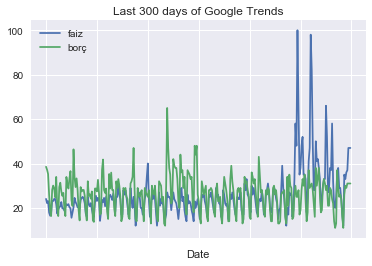

In [6]:
#plot google trends last 300 days 
interest_over_time_df.tail(300).plot(x="Date",title="Last 300 days of Google Trends")

## Exploratory Data Analysis
Data is taken from last 5 years, that is the maximum cumulative data that is available for all the features. Note that investing.com also gives maximum 5 years of data, else we need to manually use CSV files.
Since aim is to predict daily performance, from now on web scraber is better suited.
Also from 2013 to 2018 is a valid timeframe that has lots of fluctiations in Turkish market after a 2002-2011 bull period.

In [7]:
#Stock raw data 
##If runs on midday will show todays day as last row!
display(akbnk_df_base.head())
display(akbnk_df_base.tail())
print("{} columns, {} rows".format(akbnk_df_base.shape[0],akbnk_df_base.shape[1]))

,Stock,Date,High,Low,Volume,Close
0,AKBNK,2013-07-29 00:00:00,6.587628,6.321998,9.949063e+07,6.569919
1,AKBNK,2013-07-30 00:00:00,6.817841,6.640753,1.158941e+08,6.782423
2,AKBNK,2013-07-31 00:00:00,6.817841,6.552210,1.530419e+08,6.587628
3,AKBNK,2013-08-01 00:00:00,6.711589,6.552210,1.043049e+08,6.552210
4,AKBNK,2013-08-02 00:00:00,6.534501,6.304289,2.286122e+08,6.499084


,Stock,Date,High,Low,Volume,Close
1236,AKBNK,2018-06-25 00:00:00,7.79,7.01,4.992716e+08,7.06
1237,AKBNK,2018-06-26 00:00:00,7.25,7.07,2.836960e+08,7.25
1238,AKBNK,2018-06-27 00:00:00,7.57,7.24,3.445512e+08,7.51
1239,AKBNK,2018-06-28 00:00:00,7.55,7.41,2.290593e+08,7.48
1240,AKBNK,2018-06-29 00:00:00,7.64,7.51,3.208239e+08,7.52


1241 columns, 6 rows


In [8]:
akbnk_df_base.describe()

,High,Low,Volume,Close
count,1241.000000,1241.000000,1.241000e+03,1241.000000
mean,7.667059,7.483383,1.779431e+08,7.568485
std,1.209117,1.195931,8.224008e+07,1.201056
min,5.011555,4.914158,0.000000e+00,4.958429
25%,6.855597,6.690623,1.285844e+08,6.773110
50%,7.423842,7.255971,1.642146e+08,7.323025
75%,8.360000,8.202225,2.094075e+08,8.286303
max,10.738152,10.373822,1.022766e+09,10.623100


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a371ef0>,
      dtype=object)

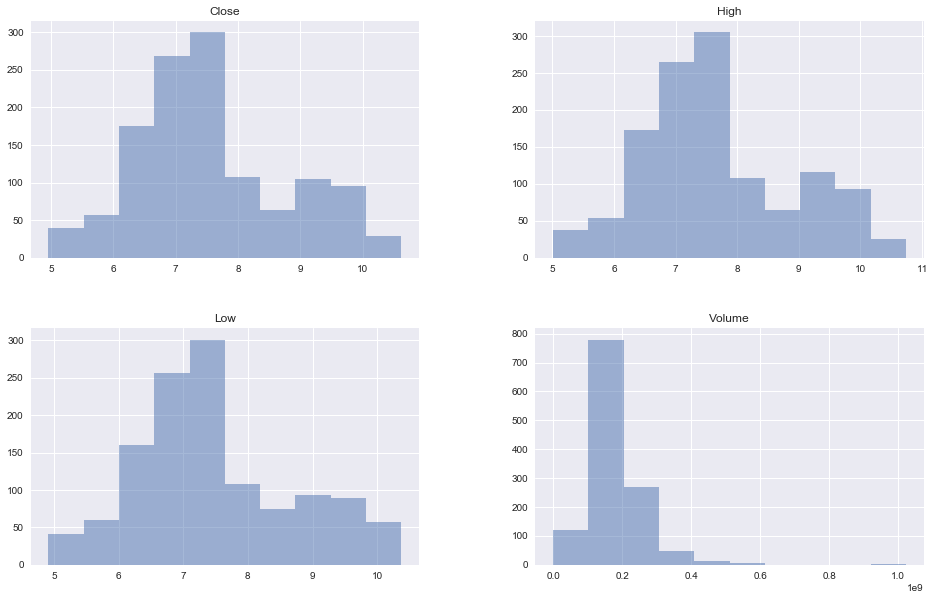

In [17]:
akbnk_df_base.hist(alpha=0.5, figsize=(16, 10))

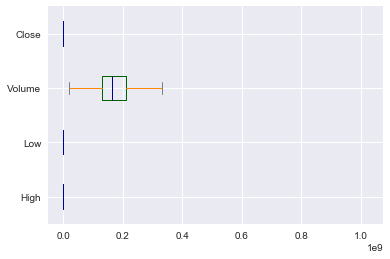

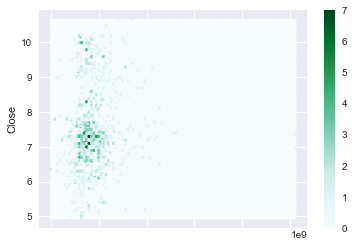

In [42]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange',
     medians='DarkBlue', caps='Gray')
akbnk_df_base.plot.box(color=color, sym='r+', vert=False)

akbnk_df_base.plot.hexbin(x="Volume",y="Close")



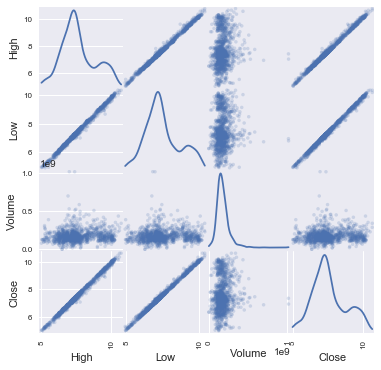

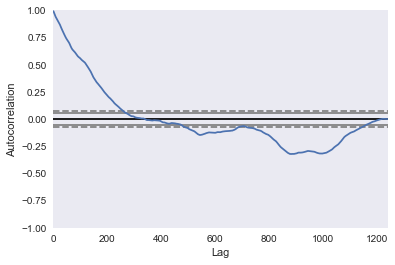

In [44]:
from pandas.plotting import scatter_matrix
scatter_matrix(akbnk_df_base, alpha=0.2, figsize=(6, 6), diagonal='kde')
plt.figure()

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(akbnk_df_base["Close"])

In [45]:
display(usdtry_df_base.describe())
display(usdtry_df_base.tail(5))

,High,Low,Close
count,1496.000000,1496.000000,1496.000000
mean,2.951163,2.930008,2.940636
std,0.683068,0.676645,0.679943
min,1.925000,1.919000,1.921000
25%,2.261750,2.241500,2.251375
50%,2.922000,2.904250,2.912000
75%,3.551000,3.532000,3.541000
max,4.930000,4.820000,4.845000


,Exchange,Date,High,Low,Close
1491,USD,2018-06-25 00:00:00,4.710,4.585,4.676
1492,USD,2018-06-26 00:00:00,4.690,4.622,4.645
1493,USD,2018-06-27 00:00:00,4.653,4.595,4.600
1494,USD,2018-06-28 00:00:00,4.629,4.580,4.596
1495,USD,2018-06-29 00:00:00,4.583,4.562,4.568


### Visualization

Below exchange rate values (according to TRY) and BIST30 performance can be seen.
We can see some missing data on BRY/TRY and also if data is pulled when BIST is open BIST can be seen as 0.0 at last day. 


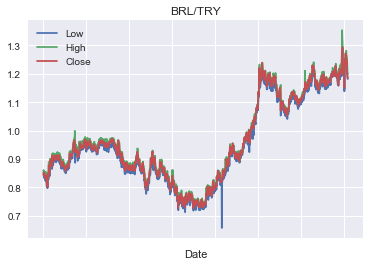

<Figure size 432x288 with 0 Axes>

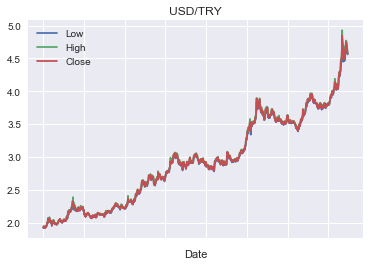

<Figure size 432x288 with 0 Axes>

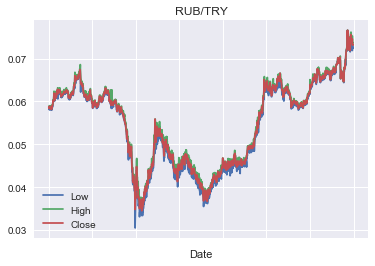

<Figure size 432x288 with 0 Axes>

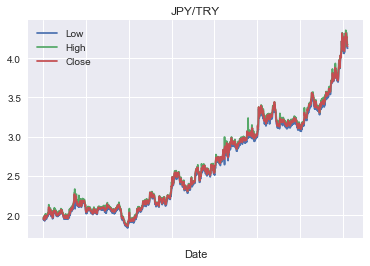

<Figure size 432x288 with 0 Axes>

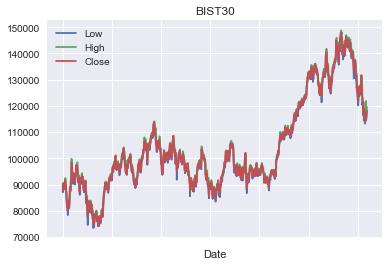

In [46]:
#there seems to be outlier on brly/try on 4-6-2016 but it is not statistically very high, so it is kept
brltry_df_base.plot(y=["Low","High","Close"],x="Date",title="BRL/TRY")

plt.figure()
usdtry_df_base.plot(y=["Low","High","Close"],x="Date",title="USD/TRY")

plt.figure()
rubtry_df_base.plot(y=["Low","High","Close"],x="Date",title="RUB/TRY")

plt.figure()
jpytry_df_base.plot(y=["Low","High","Close"],x="Date",title="JPY/TRY")

plt.figure()
bist30_df_base.plot(y=["Low","High","Close"],x="Date",title="BIST30")




In [47]:
bist30_df_base.iloc[-1]

Date      2018-06-29 00:00:00
High                   119546
Low                    117825
Volume            5.09154e+09
Close                  118104
Name: 1238, dtype: object

In [48]:
#Outlier handling 
def find_zero_and_replace(df,drop=False):
    #replace zero with nearest value
    df= df.replace(to_replace=0.0, method='ffill')
    return df
def replace_zeroes_in_df(df):
    for col in df.columns:
        df[col] = find_zero_and_replace(df[col])
        
    return df



<Figure size 432x288 with 0 Axes>

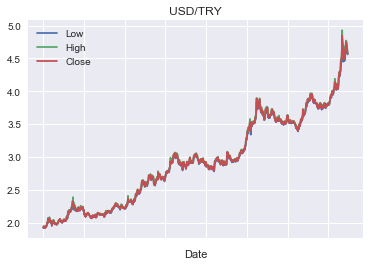

In [49]:
usdtry_df_base = replace_zeroes_in_df(usdtry_df_base)
plt.figure()
usdtry_df_base.plot(y=["Low","High","Close"],x="Date",title="USD/TRY")




In [50]:
#delete todays value of bist.. (0 if it is pulled midday)
print("Bist30 before 0 drop")
display(bist30_df_base.loc[(bist30_df_base["Close"]==0)])
bist30_df_base.drop( (bist30_df_base.loc[(bist30_df_base["Close"]==0)].index), inplace=True)

print("Bist30 after 0 drop")
display(bist30_df_base.loc[(bist30_df_base["Close"]==0)])




Bist30 before 0 drop


,Date,High,Low,Volume,Close


Bist30 after 0 drop


,Date,High,Low,Volume,Close


### Visualize target performance vs USD.

Text(0.5,0,'Date')

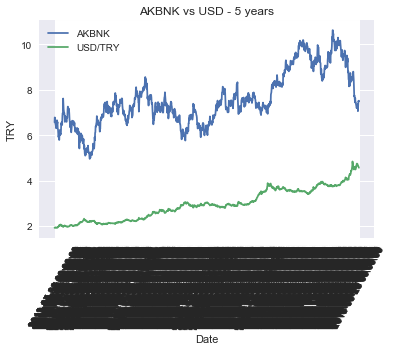

In [51]:
#Visualization
df_vis = pd.merge(akbnk_df_base,
               usdtry_df_base
               ,how="inner", on="Date", suffixes=("_stock","_usd"))

plt.plot(df_vis["Date"],df_vis[["Close_stock","Close_usd"]], )
plt.legend(['AKBNK', 'USD/TRY'], loc='upper left')
plt.title("AKBNK vs USD - 5 years")
plt.xticks(rotation=60)
plt.ylabel("TRY")
plt.xlabel("Date")


Text(0.5,0,'Date')

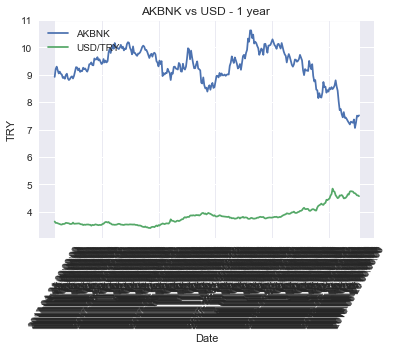

In [52]:
#Visualization - Last 1 year
last_x_days = 300

plt.plot(df_vis["Date"].tail(last_x_days),df_vis[["Close_stock","Close_usd"]].tail(last_x_days), )
plt.legend(['AKBNK', 'USD/TRY'], loc='upper left')
plt.title("AKBNK vs USD - 1 year ")
plt.xticks(rotation=60)
plt.ylabel("TRY")
plt.xlabel("Date")



Text(0.5,0,'Date')

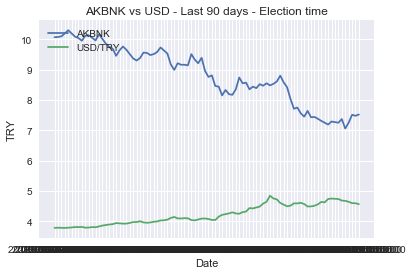

In [53]:
#Visualization - Last 90 days
last_x_days = 90
plt.plot(df_vis["Date"].tail(last_x_days),df_vis[["Close_stock","Close_usd"]].tail(last_x_days), )
plt.legend(['AKBNK', 'USD/TRY'], loc='upper left')
plt.title("AKBNK vs USD - Last 90 days - Election time")
#plt.xticks(rotation=60)
plt.ylabel("TRY")
plt.xlabel("Date")

In [54]:

#Generate base stock features
#Sort date
#Convert High, Low, Volume , Close to percentage according to previous day
#Remove duplicate dates

print("Generating stock features")

akbnk_df = generate_features_for_df(akbnk_df_base,has_volume=True, is_target=True)
#thyao_df = generate_features_for_df(thyao_df_base,has_volume=True, is_target=True)
#ttrak_df = generate_features_for_df(ttrak_df_base,has_volume=True, is_target=True)
#tuprs_df = generate_features_for_df(tuprs_df_base,has_volume=True, is_target=True)


#tcell_df = generate_features_for_df(tcell_df_base,has_volume=True, is_target=True)
#alctl_df = generate_features_for_df(alctl_df_base,has_volume=True, is_target=True)
#asuzu_df = generate_features_for_df(asuzu_df_base,has_volume=True, is_target=True)



#Generate exchange features
print("Generating exchange features")
usdtry_df= generate_features_for_df(usdtry_df_base,has_volume=False, no_extra=True)
brltry_df= generate_features_for_df(brltry_df_base,has_volume=False, no_extra=True)
rubtry_df= generate_features_for_df(rubtry_df_base,has_volume=False, no_extra=True)
jpytry_df= generate_features_for_df(jpytry_df_base,has_volume=False, no_extra=True)






Generating stock features
Generating exchange features


In [55]:
#Generate Index features
print("Generating Bist30 features")
#change bist volume  hasVolume to see impact
bist30_df= generate_features_for_df(bist30_df_base,has_volume=False, no_extra=True)
bist30_df.drop(["Volume"],axis=1,inplace=True)
#bist100_df= generate_features_for_df(bist100_df_base,hasVolume=False)




Generating Bist30 features


#### Plot Features

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline 

#Plot stock features 
def plot_stock(stock_df,last_x_days=300,name=""):
    plt.figure()
   
    stock_df.tail(last_x_days).plot(y=["High","Close","Low","CCI_indicator","DPO_indicator"],x="Date",title=name);
    plt.subplot()

    stock_df.tail(last_x_days).plot(y=["RSI_indicator","EMA_F_indicator","MACD_Signal"],x="Date");
    plt.title("More Technical Indicators")



/Users/gorkemgoknar/Documents/anaconda3/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

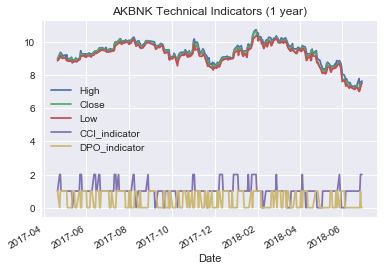

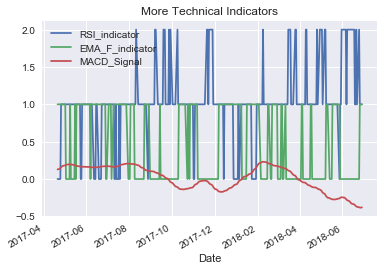

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline 

plot_stock(akbnk_df.tail(365), name="AKBNK Technical Indicators (1 year)")
#plot_stock(asuzu_df)

Above, RSI = 2 usually means sell (overbought stock) , RSI = 1 means buy (underbought stock)
Indicator calculations can be seen capstone_module.py

In [58]:
#all calculated features for stock
#raw indicators will be dropped after merging

#Here Next_day_prediction is the target value
#Next_day_buy_price is close value next days, will be used for simulation
akbnk_df.columns

Index(['Stock', 'Date', 'High', 'Low', 'Volume', 'Close', 'Day_of_week', 'Days_from_last_open', 'High_Close_perc', 'Close_Low_perc', 'Prev_Day_Close_perc', 'Next_day_prediction', 'Next_day_buy_price', 'Prev_Day_Volume_Change', 'RSI_indicator', 'ATR', 'DON_HBAND_IND', 'DON_LBAND_IND', 'ADX', 'CCI_indicator', 'MACD_Signal', 'EMA_F_indicator', 'EMA_S_indicator', 'MACD', 'DPO_indicator', 'ICH_A', 'ICH_B', 'Trix'], dtype='object')

In [59]:
#all calculated features for index or exchange
#raw indicators will be dropped after merging

#Some of the core indicators for stock are not included for reducing curse of dimensionality
usdtry_df.columns

Index(['Exchange', 'Date', 'High', 'Low', 'Close', 'High_Close_perc', 'Close_Low_perc', 'Prev_Day_Close_perc', 'RSI_indicator', 'CCI_indicator', 'MACD_Signal', 'EMA_F_indicator', 'EMA_S_indicator'], dtype='object')

### Join features 
Features are combined in a single dataframe wih inner join by Date. 
Note that all dates are normalized to day and also duplicates are removed in feature generation step

In [74]:
#JOIN FEATURES into single dataframe
stock_to_predict = akbnk_df #thyao_df akbnk_df, ttrak_df, tcell_df, hekts_df, alctl_df

cols_to_remove_for_exchange = ["Exchange","High", "Low"]
cols_to_remove_for_index = ["High",	"Low"]


print("Base Stock shape:", stock_to_predict.shape)
df2 = pd.merge(stock_to_predict,
               usdtry_df.drop(cols_to_remove_for_exchange,axis=1)
               ,how="inner", on="Date", suffixes=("_stock","_usd"))

display(df2.tail(5))

print("DF2 shape (stock+usd):", df2.shape)

df2 = pd.merge(df2,
               brltry_df.drop(cols_to_remove_for_exchange,axis=1)
                ,how="inner", on="Date", suffixes=("_stock","_bry"))


display(df2.tail(5))
print("DF2 shape (df2+bry):", df2.shape)

df2 = pd.merge(df2,
               rubtry_df.drop(cols_to_remove_for_exchange,axis=1)
                ,how="inner", on="Date", suffixes=("_bry","_rub"))
#Note close is bry now

display(df2.tail(5))

print("DF2 shape (df2+rub):", df2.shape)

df2 = pd.merge(df2,
               jpytry_df.drop(cols_to_remove_for_exchange,axis=1)
                ,how="inner", on="Date", suffixes=("_rub","_jpy"))
print("DF2 shape (df2+jpy):", df2.shape)

df2 = pd.merge(df2,
               bist30_df.drop(cols_to_remove_for_index,axis=1)
                ,how="inner", on="Date", suffixes=("_jpy","_bist30"))
print("DF2 shape (df2+bist30):", df2.shape)

##Since google trend has different timestamp we want to have date column only
df2['Date'] = df2['Date'].dt.normalize()


#join google trend data
df2 = pd.merge(df2,interest_over_time_df,how="inner", on="Date", suffixes=("_m","_goog"))
print("DF2 shape (df2+google trend):", df2.shape)

df2.drop_duplicates(keep='first', inplace=False)
display(df2.tail(5))




Base Stock shape: (1241, 28)


,Stock,Date,High,Low,Volume,Close_stock,Day_of_week,Days_from_last_open,High_Close_perc_stock,Close_Low_perc_stock,Prev_Day_Close_perc_stock,Next_day_prediction,Next_day_buy_price,Prev_Day_Volume_Change,RSI_indicator_stock,ATR,DON_HBAND_IND,DON_LBAND_IND,ADX,CCI_indicator_stock,MACD_Signal_stock,EMA_F_indicator_stock,EMA_S_indicator_stock,MACD,DPO_indicator,ICH_A,ICH_B,Trix,Close_usd,High_Close_perc_usd,Close_Low_perc_usd,Prev_Day_Close_perc_usd,RSI_indicator_usd,CCI_indicator_usd,MACD_Signal_usd,EMA_F_indicator_usd,EMA_S_indicator_usd
1234,AKBNK,2018-06-25,7.79,7.01,4.992716e+08,7.06,0,3.0,-10.339943,0.708215,-4.390935,1,7.06,24.843647,2,0.284337,0.0,1.0,57.001231,1,-0.377729,0,0,-0.412427,0,7.8800,8.100,-0.446430,4.676,-0.727117,1.946108,-0.213858,1,1,0.110042,0,1
1235,AKBNK,2018-06-26,7.25,7.07,2.836960e+08,7.25,1,1.0,0.000000,2.482759,2.620690,1,7.25,-75.988202,1,0.268614,0.0,0.0,64.167693,1,-0.382018,1,0,-0.407755,0,7.7625,8.035,-0.387087,4.645,-0.968784,0.495156,-0.667384,1,1,0.108900,0,1
1236,AKBNK,2018-06-27,7.57,7.24,3.445512e+08,7.51,2,1.0,-0.798935,3.595206,3.462051,0,7.51,17.662140,1,0.278845,1.0,0.0,70.139744,2,-0.383257,1,0,-0.390689,1,7.7175,8.035,-0.178599,4.600,-1.152174,0.108696,-0.978261,1,1,0.107094,0,0
1237,AKBNK,2018-06-28,7.55,7.41,2.290593e+08,7.48,3,1.0,-0.935829,0.935829,-0.401070,1,7.48,-50.420037,1,0.255704,0.0,0.0,75.116453,2,-0.382152,1,0,-0.375521,0,7.6675,8.035,0.012404,4.596,-0.718016,0.348129,-0.087032,1,1,0.104746,0,0
1238,AKBNK,2018-06-29,7.64,7.51,3.208239e+08,7.52,4,1.0,-1.595745,0.132979,0.531915,0,7.52,28.602773,1,0.239754,1.0,0.0,79.263711,2,-0.378849,1,0,-0.359031,0,7.5225,8.035,0.168247,4.568,-0.328371,0.131349,-0.612960,2,0,0.101811,0,0


DF2 shape (stock+usd): (1239, 37)


,Stock,Date,High,Low,Volume,Close_stock,Day_of_week,Days_from_last_open,High_Close_perc_stock,Close_Low_perc_stock,Prev_Day_Close_perc_stock,Next_day_prediction,Next_day_buy_price,Prev_Day_Volume_Change,RSI_indicator_stock,ATR,DON_HBAND_IND,DON_LBAND_IND,ADX,CCI_indicator_stock,MACD_Signal_stock,EMA_F_indicator_stock,EMA_S_indicator_stock,MACD,DPO_indicator,ICH_A,ICH_B,Trix,Close_usd,High_Close_perc_usd,Close_Low_perc_usd,Prev_Day_Close_perc_usd,RSI_indicator_usd,CCI_indicator_usd,MACD_Signal_usd,EMA_F_indicator_usd,EMA_S_indicator_usd,Close,High_Close_perc,Close_Low_perc,Prev_Day_Close_perc,RSI_indicator,CCI_indicator,MACD_Signal,EMA_F_indicator,EMA_S_indicator
1234,AKBNK,2018-06-25,7.79,7.01,4.992716e+08,7.06,0,3.0,-10.339943,0.708215,-4.390935,1,7.06,24.843647,2,0.284337,0.0,1.0,57.001231,1,-0.377729,0,0,-0.412427,0,7.8800,8.100,-0.446430,4.676,-0.727117,1.946108,-0.213858,1,1,0.110042,0,1,1.2437,-0.619120,3.409182,0.361824,1,0,0.008757,0,0
1235,AKBNK,2018-06-26,7.25,7.07,2.836960e+08,7.25,1,1.0,0.000000,2.482759,2.620690,1,7.25,-75.988202,1,0.268614,0.0,0.0,64.167693,1,-0.382018,1,0,-0.407755,0,7.7625,8.035,-0.387087,4.645,-0.968784,0.495156,-0.667384,1,1,0.108900,0,1,1.2158,-2.895213,0.065800,-2.294785,1,0,0.008635,0,0
1236,AKBNK,2018-06-27,7.57,7.24,3.445512e+08,7.51,2,1.0,-0.798935,3.595206,3.462051,0,7.51,17.662140,1,0.278845,1.0,0.0,70.139744,2,-0.383257,1,0,-0.390689,1,7.7175,8.035,-0.178599,4.600,-1.152174,0.108696,-0.978261,1,1,0.107094,0,0,1.2007,-2.331973,0.524694,-1.257600,2,0,0.008243,0,0
1237,AKBNK,2018-06-28,7.55,7.41,2.290593e+08,7.48,3,1.0,-0.935829,0.935829,-0.401070,1,7.48,-50.420037,1,0.255704,0.0,0.0,75.116453,2,-0.382152,1,0,-0.375521,0,7.6675,8.035,0.012404,4.596,-0.718016,0.348129,-0.087032,1,1,0.104746,0,0,1.1901,-1.420049,0.117637,-0.890681,2,0,0.007588,0,0
1238,AKBNK,2018-06-29,7.64,7.51,3.208239e+08,7.52,4,1.0,-1.595745,0.132979,0.531915,0,7.52,28.602773,1,0.239754,1.0,0.0,79.263711,2,-0.378849,1,0,-0.359031,0,7.5225,8.035,0.168247,4.568,-0.328371,0.131349,-0.612960,2,0,0.101811,0,0,1.1852,-1.198110,0.278434,-0.413432,2,0,0.006719,0,0


DF2 shape (df2+bry): (1239, 46)


,Stock,Date,High,Low,Volume,Close_stock,Day_of_week,Days_from_last_open,High_Close_perc_stock,Close_Low_perc_stock,Prev_Day_Close_perc_stock,Next_day_prediction,Next_day_buy_price,Prev_Day_Volume_Change,RSI_indicator_stock,ATR,DON_HBAND_IND,DON_LBAND_IND,ADX,CCI_indicator_stock,MACD_Signal_stock,EMA_F_indicator_stock,EMA_S_indicator_stock,MACD,DPO_indicator,ICH_A,ICH_B,Trix,Close_usd,High_Close_perc_usd,Close_Low_perc_usd,Prev_Day_Close_perc_usd,RSI_indicator_usd,CCI_indicator_usd,MACD_Signal_usd,EMA_F_indicator_usd,EMA_S_indicator_usd,Close_bry,High_Close_perc_bry,Close_Low_perc_bry,Prev_Day_Close_perc_bry,RSI_indicator_bry,CCI_indicator_bry,MACD_Signal_bry,EMA_F_indicator_bry,EMA_S_indicator_bry,Close_rub,High_Close_perc_rub,Close_Low_perc_rub,Prev_Day_Close_perc_rub,RSI_indicator_rub,CCI_indicator_rub,MACD_Signal_rub,EMA_F_indicator_rub,EMA_S_indicator_rub
1234,AKBNK,2018-06-25,7.79,7.01,4.992716e+08,7.06,0,3.0,-10.339943,0.708215,-4.390935,1,7.06,24.843647,2,0.284337,0.0,1.0,57.001231,1,-0.377729,0,0,-0.412427,0,7.8800,8.100,-0.446430,4.676,-0.727117,1.946108,-0.213858,1,1,0.110042,0,1,1.2437,-0.619120,3.409182,0.361824,1,0,0.008757,0,0,0.07458,-0.817914,3.606865,0.348619,1,0,0.001137,0,0
1235,AKBNK,2018-06-26,7.25,7.07,2.836960e+08,7.25,1,1.0,0.000000,2.482759,2.620690,1,7.25,-75.988202,1,0.268614,0.0,0.0,64.167693,1,-0.382018,1,0,-0.407755,0,7.7625,8.035,-0.387087,4.645,-0.968784,0.495156,-0.667384,1,1,0.108900,0,1,1.2158,-2.895213,0.065800,-2.294785,1,0,0.008635,0,0,0.07331,-2.646297,0.177329,-1.732369,1,1,0.001110,0,0
1236,AKBNK,2018-06-27,7.57,7.24,3.445512e+08,7.51,2,1.0,-0.798935,3.595206,3.462051,0,7.51,17.662140,1,0.278845,1.0,0.0,70.139744,2,-0.383257,1,0,-0.390689,1,7.7175,8.035,-0.178599,4.600,-1.152174,0.108696,-0.978261,1,1,0.107094,0,0,1.2007,-2.331973,0.524694,-1.257600,2,0,0.008243,0,0,0.07338,-0.585991,0.722268,0.095394,1,0,0.001077,0,0
1237,AKBNK,2018-06-28,7.55,7.41,2.290593e+08,7.48,3,1.0,-0.935829,0.935829,-0.401070,1,7.48,-50.420037,1,0.255704,0.0,0.0,75.116453,2,-0.382152,1,0,-0.375521,0,7.6675,8.035,0.012404,4.596,-0.718016,0.348129,-0.087032,1,1,0.104746,0,0,1.1901,-1.420049,0.117637,-0.890681,2,0,0.007588,0,0,0.07318,-0.573927,0.997540,-0.273299,1,0,0.001038,0,0
1238,AKBNK,2018-06-29,7.64,7.51,3.208239e+08,7.52,4,1.0,-1.595745,0.132979,0.531915,0,7.52,28.602773,1,0.239754,1.0,0.0,79.263711,2,-0.378849,1,0,-0.359031,0,7.5225,8.035,0.168247,4.568,-0.328371,0.131349,-0.612960,2,0,0.101811,0,0,1.1852,-1.198110,0.278434,-0.413432,2,0,0.006719,0,0,0.07318,-0.710577,0.929216,0.000000,1,1,0.000996,0,0


DF2 shape (df2+rub): (1239, 55)
DF2 shape (df2+jpy): (1239, 64)
DF2 shape (df2+bist30): (1238, 73)
DF2 shape (df2+google trend): (1238, 75)


,Stock,Date,High,Low,Volume,Close_stock,Day_of_week,Days_from_last_open,High_Close_perc_stock,Close_Low_perc_stock,Prev_Day_Close_perc_stock,Next_day_prediction,Next_day_buy_price,Prev_Day_Volume_Change,RSI_indicator_stock,ATR,DON_HBAND_IND,DON_LBAND_IND,ADX,CCI_indicator_stock,MACD_Signal_stock,EMA_F_indicator_stock,EMA_S_indicator_stock,MACD,DPO_indicator,ICH_A,ICH_B,Trix,Close_usd,High_Close_perc_usd,Close_Low_perc_usd,Prev_Day_Close_perc_usd,RSI_indicator_usd,CCI_indicator_usd,MACD_Signal_usd,EMA_F_indicator_usd,EMA_S_indicator_usd,Close_bry,High_Close_perc_bry,Close_Low_perc_bry,Prev_Day_Close_perc_bry,RSI_indicator_bry,CCI_indicator_bry,MACD_Signal_bry,EMA_F_indicator_bry,EMA_S_indicator_bry,Close_rub,High_Close_perc_rub,Close_Low_perc_rub,Prev_Day_Close_perc_rub,RSI_indicator_rub,CCI_indicator_rub,MACD_Signal_rub,EMA_F_indicator_rub,EMA_S_indicator_rub,Close_jpy,High_Close_perc_jpy,Close_Low_perc_jpy,Prev_Day_Close_perc_jpy,RSI_indicator_jpy,CCI_indicator_jpy,MACD_Signal_jpy,EMA_F_indicator_jpy,EMA_S_indicator_jpy,Close_bist30,High_Close_perc_bist30,Close_Low_perc_bist30,Prev_Day_Close_perc_bist30,RSI_indicator_bist30,CCI_indicator_bist30,MACD_Signal_bist30,EMA_F_indicator_bist30,EMA_S_indicator_bist30,faiz,borç
1233,AKBNK,2018-06-25,7.79,7.01,4.992716e+08,7.06,0,3.0,-10.339943,0.708215,-4.390935,1,7.06,24.843647,2,0.284337,0.0,1.0,57.001231,1,-0.377729,0,0,-0.412427,0,7.8800,8.100,-0.446430,4.676,-0.727117,1.946108,-0.213858,1,1,0.110042,0,1,1.2437,-0.619120,3.409182,0.361824,1,0,0.008757,0,0,0.07458,-0.817914,3.606865,0.348619,1,0,0.001137,0,0,4.2740,-1.165185,2.884885,0.308844,1,1,0.078946,0,1,115134.17,-5.861674,0.726578,-2.068578,1,1,-3670.118834,0,0,35.0,26.0
1234,AKBNK,2018-06-26,7.25,7.07,2.836960e+08,7.25,1,1.0,0.000000,2.482759,2.620690,1,7.25,-75.988202,1,0.268614,0.0,0.0,64.167693,1,-0.382018,1,0,-0.407755,0,7.7625,8.035,-0.387087,4.645,-0.968784,0.495156,-0.667384,1,1,0.108900,0,1,1.2158,-2.895213,0.065800,-2.294785,1,0,0.008635,0,0,0.07331,-2.646297,0.177329,-1.732369,1,1,0.001110,0,0,4.2008,-2.582841,0.209484,-1.742525,1,0,0.077765,0,0,115806.90,-0.770135,0.724007,0.580907,1,1,-3695.897713,0,0,33.0,30.0
1235,AKBNK,2018-06-27,7.57,7.24,3.445512e+08,7.51,2,1.0,-0.798935,3.595206,3.462051,0,7.51,17.662140,1,0.278845,1.0,0.0,70.139744,2,-0.383257,1,0,-0.390689,1,7.7175,8.035,-0.178599,4.600,-1.152174,0.108696,-0.978261,1,1,0.107094,0,0,1.2007,-2.331973,0.524694,-1.257600,2,0,0.008243,0,0,0.07338,-0.585991,0.722268,0.095394,1,0,0.001077,0,0,4.2021,-1.180362,0.773423,0.030937,1,0,0.076131,0,0,117742.40,-0.285946,1.868910,1.643843,1,1,-3699.625115,1,0,36.0,29.0
1236,AKBNK,2018-06-28,7.55,7.41,2.290593e+08,7.48,3,1.0,-0.935829,0.935829,-0.401070,1,7.48,-50.420037,1,0.255704,0.0,0.0,75.116453,2,-0.382152,1,0,-0.375521,0,7.6675,8.035,0.012404,4.596,-0.718016,0.348129,-0.087032,1,1,0.104746,0,0,1.1901,-1.420049,0.117637,-0.890681,2,0,0.007588,0,0,0.07318,-0.573927,0.997540,-0.273299,1,0,0.001038,0,0,4.1575,-1.587492,0.079375,-1.072760,2,0,0.073875,0,0,118083.16,-0.787039,0.886248,0.288576,1,2,-3682.507180,1,0,37.0,31.0
1237,AKBNK,2018-06-29,7.64,7.51,3.208239e+08,7.52,4,1.0,-1.595745,0.132979,0.531915,0,7.52,28.602773,1,0.239754,1.0,0.0,79.263711,2,-0.378849,1,0,-0.359031,0,7.5225,8.035,0.168247,4.568,-0.328371,0.131349,-0.612960,2,0,0.101811,0,0,1.1852,-1.198110,0.278434,-0.413432,2,0,0.006719,0,0,0.07318,-0.710577,0.929216,0.000000,1,1,0.000996,0,0,4.1517,-0.525086,0.592528,-0.139702,2,0,0.071128,0,0,118103.89,-1.220798,0.236114,0.017552,1,2,-3647.905727,1,0,47.0,31.0


In [75]:

#Remove stocks raw data except Close
cols_to_remove_final = ["High",	"Low","Stock","Volume"]
##Close_stock will be removed finaly, need date and close index from train/test data
df2.drop(cols_to_remove_final,axis=1,inplace=True)

print("DF2 shape before Nan drop:", df2.shape)

#if still has nan drop colms
#drop columns that has more than 20% nan
df2 = df2.dropna(thresh=2/10*len(df2), axis=1)
print("DF2 shape (drop 20% nan colmns):", df2.shape)

display(df2.tail(10))



DF2 shape before Nan drop: (1238, 71)
DF2 shape (drop 20% nan colmns): (1238, 71)


,Date,Close_stock,Day_of_week,Days_from_last_open,High_Close_perc_stock,Close_Low_perc_stock,Prev_Day_Close_perc_stock,Next_day_prediction,Next_day_buy_price,Prev_Day_Volume_Change,RSI_indicator_stock,ATR,DON_HBAND_IND,DON_LBAND_IND,ADX,CCI_indicator_stock,MACD_Signal_stock,EMA_F_indicator_stock,EMA_S_indicator_stock,MACD,DPO_indicator,ICH_A,ICH_B,Trix,Close_usd,High_Close_perc_usd,Close_Low_perc_usd,Prev_Day_Close_perc_usd,RSI_indicator_usd,CCI_indicator_usd,MACD_Signal_usd,EMA_F_indicator_usd,EMA_S_indicator_usd,Close_bry,High_Close_perc_bry,Close_Low_perc_bry,Prev_Day_Close_perc_bry,RSI_indicator_bry,CCI_indicator_bry,MACD_Signal_bry,EMA_F_indicator_bry,EMA_S_indicator_bry,Close_rub,High_Close_perc_rub,Close_Low_perc_rub,Prev_Day_Close_perc_rub,RSI_indicator_rub,CCI_indicator_rub,MACD_Signal_rub,EMA_F_indicator_rub,EMA_S_indicator_rub,Close_jpy,High_Close_perc_jpy,Close_Low_perc_jpy,Prev_Day_Close_perc_jpy,RSI_indicator_jpy,CCI_indicator_jpy,MACD_Signal_jpy,EMA_F_indicator_jpy,EMA_S_indicator_jpy,Close_bist30,High_Close_perc_bist30,Close_Low_perc_bist30,Prev_Day_Close_perc_bist30,RSI_indicator_bist30,CCI_indicator_bist30,MACD_Signal_bist30,EMA_F_indicator_bist30,EMA_S_indicator_bist30,faiz,borç
1228,2018-06-18,7.19,0,4.0,-1.668985,0.834492,-0.834492,1,7.19,25.774391,2,0.232904,0.0,1.0,62.998070,1,-0.339538,0,0,-0.406720,0,8.2350,8.235,-0.953350,4.737,-0.063331,0.569981,2.322145,0,2,0.112328,1,1,1.2588,-1.310772,0.166826,-0.913568,1,1,0.006674,1,1,0.07438,-1.680559,0.268889,-0.914224,1,1,0.001229,1,1,4.2645,-0.968461,0.494783,-0.396295,1,1,0.080184,1,1,114197.46,-1.495261,0.330577,-1.888501,2,0,-3380.280056,0,0,36.0,37.0
1229,2018-06-19,7.29,1,1.0,-0.960219,2.057613,1.371742,0,7.29,28.204127,1,0.230753,0.0,0.0,58.053947,1,-0.349600,0,0,-0.409971,0,8.2175,8.235,-0.842459,4.751,-0.484109,0.231530,0.294675,0,2,0.111589,1,1,1.2701,-0.535391,1.094402,0.889694,1,1,0.007189,1,1,0.07447,-0.349134,0.617698,0.120854,1,1,0.001217,1,1,4.3210,-0.819255,1.381625,1.307568,0,1,0.080097,1,1,116040.02,-0.335919,2.432238,1.587866,1,1,-3463.668665,0,0,38.0,29.0
1230,2018-06-20,7.27,2,1.0,-0.962861,0.687758,-0.275103,0,7.27,2.141899,1,0.212294,0.0,0.0,58.378289,1,-0.358496,0,0,-0.411876,0,8.1700,8.215,-0.718294,4.744,-0.379427,0.337268,-0.147555,0,1,0.111252,1,1,1.2571,-1.925066,0.182961,-1.034126,1,1,0.007682,1,1,0.07456,-0.710837,0.496245,0.120708,1,1,0.001204,1,1,4.2969,-0.975122,0.016291,-0.560869,1,1,0.080103,1,1,116090.07,-0.807054,0.954182,0.043113,1,1,-3536.895639,0,0,29.0,25.0
1231,2018-06-21,7.25,3,1.0,-0.965517,0.137931,-0.275862,1,7.25,17.221933,2,0.190245,0.0,0.0,56.543311,1,-0.366226,0,0,-0.412608,0,8.0050,8.100,-0.605577,4.736,-0.591216,0.190034,-0.168919,0,1,0.111104,1,1,1.2580,-0.715421,0.890302,0.071542,1,1,0.008148,0,1,0.07438,-0.793224,0.188223,-0.242001,1,1,0.001190,1,1,4.3058,-0.438943,0.278694,0.206698,1,1,0.080183,1,1,116559.72,-0.428519,0.690830,0.402926,1,1,-3595.814168,0,0,29.0,26.0
1232,2018-06-22,7.37,4,1.0,-0.542741,1.628223,1.628223,0,7.37,23.272783,1,0.185204,1.0,0.0,48.401477,1,-0.371946,0,0,-0.406261,0,7.8975,8.100,-0.443243,4.686,-0.917627,0.149381,-1.067008,1,1,0.110721,1,1,1.2383,-1.970443,0.242268,-1.590891,1,1,0.008458,0,0,0.07450,-0.885906,0.966443,0.161074,1,1,0.001174,1,1,4.2600,-1.521127,0.309859,-1.075117,1,1,0.079982,1,1,117515.81,-0.410838,1.505312,0.813584,1,1,-3634.629521,0,0,24.0,24.0
1233,2018-06-25,7.06,0,3.0,-10.339943,0.708215,-4.390935,1,7.06,24.843647,2,0.284337,0.0,1.0,57.001231,1,-0.377729,0,0,-0.412427,0,7.8800,8.100,-0.446430,4.676,-0.727117,1.946108,-0.213858,1,1,0.110042,0,1,1.2437,-0.619120,3.409182,0.361824,1,0,0.008757,0,0,0.07458,-0.817914,3.606865,0.348619,1,0,0.001137,0,0,4.2740,-1.165185,2.884885,0.308844,1,1,0.078946,0,1,115134.17,-5.861674,0.726578,-2.068578,1,1,-3670.118834,0,0,35.0,26.0
1234,2018-06-26,7.25,1,1.0,0.000000,2.482759,2.620690,1,7.25,-75.988202,1,0.268614,0.0,0.0,64.167693,1,-0.382018,1,0,-0.407755,0,7.7625,8.035,-0.387087,4.645,-0.968784,0.495156,-0.667384,1,1,

In [76]:
#check if any remaining null or infinite
nan_indices = df2.isin([np.nan, np.inf, -np.inf]).any(1)
df2[nan_indices]

,Date,Close_stock,Day_of_week,Days_from_last_open,High_Close_perc_stock,Close_Low_perc_stock,Prev_Day_Close_perc_stock,Next_day_prediction,Next_day_buy_price,Prev_Day_Volume_Change,RSI_indicator_stock,ATR,DON_HBAND_IND,DON_LBAND_IND,ADX,CCI_indicator_stock,MACD_Signal_stock,EMA_F_indicator_stock,EMA_S_indicator_stock,MACD,DPO_indicator,ICH_A,ICH_B,Trix,Close_usd,High_Close_perc_usd,Close_Low_perc_usd,Prev_Day_Close_perc_usd,RSI_indicator_usd,CCI_indicator_usd,MACD_Signal_usd,EMA_F_indicator_usd,EMA_S_indicator_usd,Close_bry,High_Close_perc_bry,Close_Low_perc_bry,Prev_Day_Close_perc_bry,RSI_indicator_bry,CCI_indicator_bry,MACD_Signal_bry,EMA_F_indicator_bry,EMA_S_indicator_bry,Close_rub,High_Close_perc_rub,Close_Low_perc_rub,Prev_Day_Close_perc_rub,RSI_indicator_rub,CCI_indicator_rub,MACD_Signal_rub,EMA_F_indicator_rub,EMA_S_indicator_rub,Close_jpy,High_Close_perc_jpy,Close_Low_perc_jpy,Prev_Day_Close_perc_jpy,RSI_indicator_jpy,CCI_indicator_jpy,MACD_Signal_jpy,EMA_F_indicator_jpy,EMA_S_indicator_jpy,Close_bist30,High_Close_perc_bist30,Close_Low_perc_bist30,Prev_Day_Close_perc_bist30,RSI_indicator_bist30,CCI_indicator_bist30,MACD_Signal_bist30,EMA_F_indicator_bist30,EMA_S_indicator_bist30,faiz,borç


In [77]:
##Show any null value remaining 
##these values are mostly the first rows used to calculate technical indicators.
df2[df2.isnull().any(axis=1)]

,Date,Close_stock,Day_of_week,Days_from_last_open,High_Close_perc_stock,Close_Low_perc_stock,Prev_Day_Close_perc_stock,Next_day_prediction,Next_day_buy_price,Prev_Day_Volume_Change,RSI_indicator_stock,ATR,DON_HBAND_IND,DON_LBAND_IND,ADX,CCI_indicator_stock,MACD_Signal_stock,EMA_F_indicator_stock,EMA_S_indicator_stock,MACD,DPO_indicator,ICH_A,ICH_B,Trix,Close_usd,High_Close_perc_usd,Close_Low_perc_usd,Prev_Day_Close_perc_usd,RSI_indicator_usd,CCI_indicator_usd,MACD_Signal_usd,EMA_F_indicator_usd,EMA_S_indicator_usd,Close_bry,High_Close_perc_bry,Close_Low_perc_bry,Prev_Day_Close_perc_bry,RSI_indicator_bry,CCI_indicator_bry,MACD_Signal_bry,EMA_F_indicator_bry,EMA_S_indicator_bry,Close_rub,High_Close_perc_rub,Close_Low_perc_rub,Prev_Day_Close_perc_rub,RSI_indicator_rub,CCI_indicator_rub,MACD_Signal_rub,EMA_F_indicator_rub,EMA_S_indicator_rub,Close_jpy,High_Close_perc_jpy,Close_Low_perc_jpy,Prev_Day_Close_perc_jpy,RSI_indicator_jpy,CCI_indicator_jpy,MACD_Signal_jpy,EMA_F_indicator_jpy,EMA_S_indicator_jpy,Close_bist30,High_Close_perc_bist30,Close_Low_perc_bist30,Prev_Day_Close_perc_bist30,RSI_indicator_bist30,CCI_indicator_bist30,MACD_Signal_bist30,EMA_F_indicator_bist30,EMA_S_indicator_bist30,faiz,borç
0,2013-07-29,6.569919,0,NaN,-0.269547,3.773578,NaN,1,6.569919,NaN,1,0.265630,0.0,0.0,NaN,1,0.000000,1,1,0.000000,0,NaN,NaN,NaN,1.9245,-0.077942,0.181865,NaN,1,1,0.000000,1,1,0.84745,-1.598914,0.513305,-0.660806,2,1,-0.000035,0,0,0.05855,-0.426985,0.085397,-0.085397,2,1,-3.126954e-07,0,0,1.9615,-0.739230,0.688249,0.356870,0,1,0.000057,1,1,88382.31,-0.167681,1.532784,0.847421,0,1,4.683990,1,1,122.803909,92.333842
1,2013-07-30,6.782423,1,1.0,-0.522203,2.088782,3.133158,0,6.782423,14.153878,0,0.255971,0.0,0.0,NaN,1,0.001329,1,1,0.002468,0,NaN,NaN,NaN,1.9260,-0.077882,0.259605,0.077882,0,1,0.000009,1,1,0.84330,-1.458556,0.474327,-0.492114,2,1,-0.000079,0,0,0.05835,-0.771208,0.257069,-0.342759,2,1,-1.705255e-06,1,1,1.9605,-0.535578,0.943637,-0.051007,0,1,0.000092,1,1,90327.63,-0.266353,1.373113,2.153627,0,1,19.124632,1,1,122.803909,88.404742
2,2013-07-31,6.587628,2,1.0,-3.494627,0.537644,-2.956982,0,6.587628,24.272945,1,0.259793,0.0,0.0,NaN,1,0.000864,0,0,0.000123,0,NaN,NaN,NaN,1.9415,-0.206026,0.695339,0.798352,0,1,0.000109,1,1,0.85245,-0.522025,1.824154,1.073377,1,1,-0.000062,1,1,0.05885,-0.254885,1.274427,0.849618,0,1,-4.285005e-08,1,1,1.9780,-0.556117,1.567240,0.884732,0,1,0.000209,1,1,88858.83,-1.844352,0.764674,-1.652959,1,1,22.702042,0,0,129.626348,84.475642
3,2013-08-01,6.552210,3,1.0,-2.432446,0.000000,-0.540550,0,6.552210,-46.725582,1,0.227469,0.0,0.0,NaN,1,0.000087,0,0,-0.001637,0,NaN,NaN,NaN,1.9425,-0.077220,0.489060,0.051480,0,1,0.000200,1,1,0.84355,-1.582597,0.610515,-1.055065,1,1,-0.000079,0,0,0.05865,-0.596760,0.426257,-0.341006,1,1,1.017401e-06,1,1,1.9480,-2.053388,0.564682,-1.540041,1,1,0.000190,0,0,88801.60,-1.586784,0.052398,-0.064447,1,1,22.689270,1,1,129.626348,72.688343
4,2013-08-02,6.499084,4,1.0,-0.544954,2.997269,-0.817438,0,6.499084,54.374751,1,0.233168,0.0,1.0,NaN,1,-0.000912,0,0,-0.003672,0,NaN,NaN,NaN,1.9305,-0.854701,0.284900,-0.621601,1,1,0.000209,0,0,0.84420,-0.912106,1.350391,0.076996,1,1,-0.000102,0,0,0.05875,-0.425532,1.106383,0.170213,1,1,2.244852e-06,1,1,1.9475,-0.898588,0.744544,-0.025674,1,1,0.000114,0,0,89748.29,-0.264440,1.858019,1.054828,1,1,26.163302,1,1,95.514152,62.865594
5,2013-08-05,6.463667,0,3.0,-1.643835,0.273978,-0.547940,0,6.463667,-131.064408,1,0.205802,0.0,1.0,11.764423,1,-0.002038,0,0,-0.005667,0,NaN,NaN,NaN,1.9325,-0.103493,0.388098,0.465718,1,1,0.000123,0,0,0.83840,-1.932252,0.584447,-0.554628,2,1,-0.000210,0,0,0.05865,-0.596760,0.596760,0.170503,1,1,2.144620e-06,0,0,1.9620,-0.407747,1.681957,1.121305,1,1,-0.000225,1,1,89961.90,-0.971600,0.349459,0.237445,0,1,31.687535,1,1,109.159030,64.830144
6,2013-08-06,6.375124,1,1.0,-1.944433,0.000000,-1.388883,0,6.375124,-60.996750,2,0.186881,0.0,1.0,51.165469,1,-0.003528,0,0,-0.008923,0,NaN,NaN,NaN,1.9275,-0.233463,0.025940,-0.259403,1,1,0.00

In [78]:
#drop any row with nan 
df2.dropna(inplace=True)
print("DF2 shape after dropping na:", df2.shape)



DF2 shape after dropping na: (1209, 71)


In [79]:
df2[df2.isnull().any(axis=1)]

,Date,Close_stock,Day_of_week,Days_from_last_open,High_Close_perc_stock,Close_Low_perc_stock,Prev_Day_Close_perc_stock,Next_day_prediction,Next_day_buy_price,Prev_Day_Volume_Change,RSI_indicator_stock,ATR,DON_HBAND_IND,DON_LBAND_IND,ADX,CCI_indicator_stock,MACD_Signal_stock,EMA_F_indicator_stock,EMA_S_indicator_stock,MACD,DPO_indicator,ICH_A,ICH_B,Trix,Close_usd,High_Close_perc_usd,Close_Low_perc_usd,Prev_Day_Close_perc_usd,RSI_indicator_usd,CCI_indicator_usd,MACD_Signal_usd,EMA_F_indicator_usd,EMA_S_indicator_usd,Close_bry,High_Close_perc_bry,Close_Low_perc_bry,Prev_Day_Close_perc_bry,RSI_indicator_bry,CCI_indicator_bry,MACD_Signal_bry,EMA_F_indicator_bry,EMA_S_indicator_bry,Close_rub,High_Close_perc_rub,Close_Low_perc_rub,Prev_Day_Close_perc_rub,RSI_indicator_rub,CCI_indicator_rub,MACD_Signal_rub,EMA_F_indicator_rub,EMA_S_indicator_rub,Close_jpy,High_Close_perc_jpy,Close_Low_perc_jpy,Prev_Day_Close_perc_jpy,RSI_indicator_jpy,CCI_indicator_jpy,MACD_Signal_jpy,EMA_F_indicator_jpy,EMA_S_indicator_jpy,Close_bist30,High_Close_perc_bist30,Close_Low_perc_bist30,Prev_Day_Close_perc_bist30,RSI_indicator_bist30,CCI_indicator_bist30,MACD_Signal_bist30,EMA_F_indicator_bist30,EMA_S_indicator_bist30,faiz,borç


In [80]:
df2= df2.sort_values(by='Date').reset_index(drop=True)


display(df2.columns)
display(df2.tail(5))

#Note that final set does not contain previous day as todays prediction is not done.. 

Index(['Date', 'Close_stock', 'Day_of_week', 'Days_from_last_open', 'High_Close_perc_stock', 'Close_Low_perc_stock', 'Prev_Day_Close_perc_stock', 'Next_day_prediction', 'Next_day_buy_price', 'Prev_Day_Volume_Change', 'RSI_indicator_stock', 'ATR', 'DON_HBAND_IND', 'DON_LBAND_IND', 'ADX', 'CCI_indicator_stock', 'MACD_Signal_stock', 'EMA_F_indicator_stock', 'EMA_S_indicator_stock', 'MACD', 'DPO_indicator', 'ICH_A', 'ICH_B', 'Trix', 'Close_usd', 'High_Close_perc_usd', 'Close_Low_perc_usd', 'Prev_Day_Close_perc_usd', 'RSI_indicator_usd', 'CCI_indicator_usd', 'MACD_Signal_usd', 'EMA_F_indicator_usd', 'EMA_S_indicator_usd', 'Close_bry', 'High_Close_perc_bry', 'Close_Low_perc_bry', 'Prev_Day_Close_perc_bry', 'RSI_indicator_bry', 'CCI_indicator_bry', 'MACD_Signal_bry', 'EMA_F_indicator_bry', 'EMA_S_indicator_bry', 'Close_rub',
       'High_Close_perc_rub', 'Close_Low_perc_rub', 'Prev_Day_Close_perc_rub', 'RSI_indicator_rub', 'CCI_indicator_rub', 'MACD_Signal_rub', 'EMA_F_indicator_rub', 'EMA_S_

,Date,Close_stock,Day_of_week,Days_from_last_open,High_Close_perc_stock,Close_Low_perc_stock,Prev_Day_Close_perc_stock,Next_day_prediction,Next_day_buy_price,Prev_Day_Volume_Change,RSI_indicator_stock,ATR,DON_HBAND_IND,DON_LBAND_IND,ADX,CCI_indicator_stock,MACD_Signal_stock,EMA_F_indicator_stock,EMA_S_indicator_stock,MACD,DPO_indicator,ICH_A,ICH_B,Trix,Close_usd,High_Close_perc_usd,Close_Low_perc_usd,Prev_Day_Close_perc_usd,RSI_indicator_usd,CCI_indicator_usd,MACD_Signal_usd,EMA_F_indicator_usd,EMA_S_indicator_usd,Close_bry,High_Close_perc_bry,Close_Low_perc_bry,Prev_Day_Close_perc_bry,RSI_indicator_bry,CCI_indicator_bry,MACD_Signal_bry,EMA_F_indicator_bry,EMA_S_indicator_bry,Close_rub,High_Close_perc_rub,Close_Low_perc_rub,Prev_Day_Close_perc_rub,RSI_indicator_rub,CCI_indicator_rub,MACD_Signal_rub,EMA_F_indicator_rub,EMA_S_indicator_rub,Close_jpy,High_Close_perc_jpy,Close_Low_perc_jpy,Prev_Day_Close_perc_jpy,RSI_indicator_jpy,CCI_indicator_jpy,MACD_Signal_jpy,EMA_F_indicator_jpy,EMA_S_indicator_jpy,Close_bist30,High_Close_perc_bist30,Close_Low_perc_bist30,Prev_Day_Close_perc_bist30,RSI_indicator_bist30,CCI_indicator_bist30,MACD_Signal_bist30,EMA_F_indicator_bist30,EMA_S_indicator_bist30,faiz,borç
1204,2018-06-25,7.06,0,3.0,-10.339943,0.708215,-4.390935,1,7.06,24.843647,2,0.284337,0.0,1.0,57.001231,1,-0.377729,0,0,-0.412427,0,7.8800,8.100,-0.446430,4.676,-0.727117,1.946108,-0.213858,1,1,0.110042,0,1,1.2437,-0.619120,3.409182,0.361824,1,0,0.008757,0,0,0.07458,-0.817914,3.606865,0.348619,1,0,0.001137,0,0,4.2740,-1.165185,2.884885,0.308844,1,1,0.078946,0,1,115134.17,-5.861674,0.726578,-2.068578,1,1,-3670.118834,0,0,35.0,26.0
1205,2018-06-26,7.25,1,1.0,0.000000,2.482759,2.620690,1,7.25,-75.988202,1,0.268614,0.0,0.0,64.167693,1,-0.382018,1,0,-0.407755,0,7.7625,8.035,-0.387087,4.645,-0.968784,0.495156,-0.667384,1,1,0.108900,0,1,1.2158,-2.895213,0.065800,-2.294785,1,0,0.008635,0,0,0.07331,-2.646297,0.177329,-1.732369,1,1,0.001110,0,0,4.2008,-2.582841,0.209484,-1.742525,1,0,0.077765,0,0,115806.90,-0.770135,0.724007,0.580907,1,1,-3695.897713,0,0,33.0,30.0
1206,2018-06-27,7.51,2,1.0,-0.798935,3.595206,3.462051,0,7.51,17.662140,1,0.278845,1.0,0.0,70.139744,2,-0.383257,1,0,-0.390689,1,7.7175,8.035,-0.178599,4.600,-1.152174,0.108696,-0.978261,1,1,0.107094,0,0,1.2007,-2.331973,0.524694,-1.257600,2,0,0.008243,0,0,0.07338,-0.585991,0.722268,0.095394,1,0,0.001077,0,0,4.2021,-1.180362,0.773423,0.030937,1,0,0.076131,0,0,117742.40,-0.285946,1.868910,1.643843,1,1,-3699.625115,1,0,36.0,29.0
1207,2018-06-28,7.48,3,1.0,-0.935829,0.935829,-0.401070,1,7.48,-50.420037,1,0.255704,0.0,0.0,75.116453,2,-0.382152,1,0,-0.375521,0,7.6675,8.035,0.012404,4.596,-0.718016,0.348129,-0.087032,1,1,0.104746,0,0,1.1901,-1.420049,0.117637,-0.890681,2,0,0.007588,0,0,0.07318,-0.573927,0.997540,-0.273299,1,0,0.001038,0,0,4.1575,-1.587492,0.079375,-1.072760,2,0,0.073875,0,0,118083.16,-0.787039,0.886248,0.288576,1,2,-3682.507180,1,0,37.0,31.0
1208,2018-06-29,7.52,4,1.0,-1.595745,0.132979,0.531915,0,7.52,28.602773,1,0.239754,1.0,0.0,79.263711,2,-0.378849,1,0,-0.359031,0,7.5225,8.035,0.168247,4.568,-0.328371,0.131349,-0.612960,2,0,0.101811,0,0,1.1852,-1.198110,0.278434,-0.413432,2,0,0.006719,0,0,0.07318,-0.710577,0.929216,0.000000,1,1,0.000996,0,0,4.1517,-0.525086,0.592528,-0.139702,2,0,0.071128,0,0,118103.89,-1.220798,0.236114,0.017552,1,2,-3647.905727,1,0,47.0,31.0


### Show correlation of target Close price to other exchange/index close prices

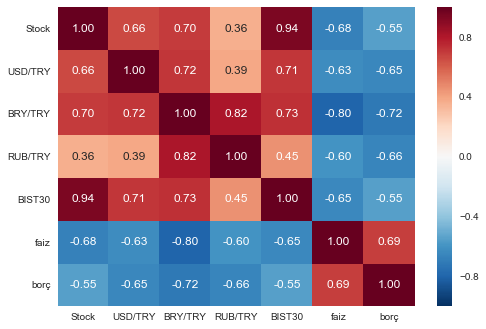

In [81]:
##VISUALIZE
import seaborn as sns
sns.set(style="white")

mpl.style.use('seaborn')

"""
x - > stock
y -> USD/TRY
Close -> bist
Close_c -> bry
Close_d -> rub


"""
#cols=["Next_day_buy_price_x","Next_day_buy_price_y","Next_day_buy_price_c","Next_day_buy_price_d","Next_day_buy_price"]
cols = ["Stock","USD/TRY","BRY/TRY","RUB/TRY","BIST30",*kw_list]
df_cor = df2.rename(columns={'Close_stock': 'Stock', 'Close_usd': 'USD/TRY','Close_bry': 'BRY/TRY','Close_rub': 'RUB/TRY','Close_bist30': 'BIST30'})
correlations = df_cor[cols].corr()
# plot correlation matrix

sns.heatmap(correlations, annot=True, fmt=".2f")




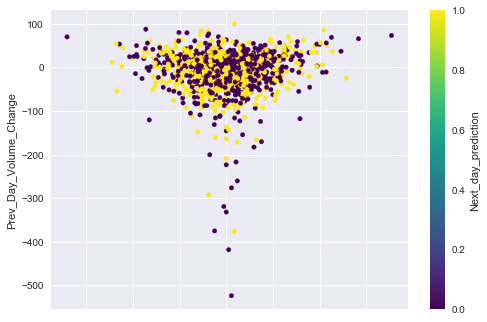

In [82]:
#from pandas.plotting import scatter_matrix
#scatter_matrix(df_cor[cols])
#plt.show()

ax2 = df2.plot.scatter(x='Prev_Day_Close_perc_stock',
                       y='Prev_Day_Volume_Change',
                       c='Next_day_prediction',
                       colormap='viridis')


### Clean merged data from unneeded columns, also label targets 

In [83]:
##CLEAN

# Clean NaN values
#df2 = df2.drop(["faiz"],axis=1)
#df2 = df2.dropna()
#df2 = clean_dataset(df2).reset_index(drop=True) #need to remove date for clean_dataset
df2 = df2.reset_index(drop=True)
df2= clean_dataset(df2)
print("DF2 shape after cleanup:", df2.shape)


##copy df2 somewhere so index and date and close can be used
orig_df2_before_train = df2.copy()
#classification
target_next_day = df2["Next_day_prediction"]
#regression
target_next_day_regression = df2["Next_day_buy_price"]
print("original df2 copyied to orig_df2_before_train:")



#usd_nex_day = df2["Next_day_prediction_y"]
#bry_nex_day = df2["Next_day_prediction_a"]

filter_next_day = [col for col in df2 if col.startswith('Next_day_')]
filter_close = [col for col in df2 if col.startswith('Close')]

##Do not delete close columns for all
##alternative test
#filter_close = []

#Date column no more
#df2.drop(["Date","Close", *filter_next_day],axis=1,inplace=True)
df2.drop(["Date", *filter_next_day, *filter_close],axis=1,inplace=True)
print("DF2 shape after final drop:", df2.shape)



DF2 shape after cleanup: (1209, 71)
original df2 copyied to orig_df2_before_train:
DF2 shape after final drop: (1209, 56)


In [84]:
#this dataframe is to be preserved for simulation
orig_df2_before_train.tail()

,Date,Close_stock,Day_of_week,Days_from_last_open,High_Close_perc_stock,Close_Low_perc_stock,Prev_Day_Close_perc_stock,Next_day_prediction,Next_day_buy_price,Prev_Day_Volume_Change,RSI_indicator_stock,ATR,DON_HBAND_IND,DON_LBAND_IND,ADX,CCI_indicator_stock,MACD_Signal_stock,EMA_F_indicator_stock,EMA_S_indicator_stock,MACD,DPO_indicator,ICH_A,ICH_B,Trix,Close_usd,High_Close_perc_usd,Close_Low_perc_usd,Prev_Day_Close_perc_usd,RSI_indicator_usd,CCI_indicator_usd,MACD_Signal_usd,EMA_F_indicator_usd,EMA_S_indicator_usd,Close_bry,High_Close_perc_bry,Close_Low_perc_bry,Prev_Day_Close_perc_bry,RSI_indicator_bry,CCI_indicator_bry,MACD_Signal_bry,EMA_F_indicator_bry,EMA_S_indicator_bry,Close_rub,High_Close_perc_rub,Close_Low_perc_rub,Prev_Day_Close_perc_rub,RSI_indicator_rub,CCI_indicator_rub,MACD_Signal_rub,EMA_F_indicator_rub,EMA_S_indicator_rub,Close_jpy,High_Close_perc_jpy,Close_Low_perc_jpy,Prev_Day_Close_perc_jpy,RSI_indicator_jpy,CCI_indicator_jpy,MACD_Signal_jpy,EMA_F_indicator_jpy,EMA_S_indicator_jpy,Close_bist30,High_Close_perc_bist30,Close_Low_perc_bist30,Prev_Day_Close_perc_bist30,RSI_indicator_bist30,CCI_indicator_bist30,MACD_Signal_bist30,EMA_F_indicator_bist30,EMA_S_indicator_bist30,faiz,borç
1204,2018-06-25,7.06,0,3.0,-10.339943,0.708215,-4.390935,1,7.06,24.843647,2,0.284337,0.0,1.0,57.001231,1,-0.377729,0,0,-0.412427,0,7.8800,8.100,-0.446430,4.676,-0.727117,1.946108,-0.213858,1,1,0.110042,0,1,1.2437,-0.619120,3.409182,0.361824,1,0,0.008757,0,0,0.07458,-0.817914,3.606865,0.348619,1,0,0.001137,0,0,4.2740,-1.165185,2.884885,0.308844,1,1,0.078946,0,1,115134.17,-5.861674,0.726578,-2.068578,1,1,-3670.118834,0,0,35.0,26.0
1205,2018-06-26,7.25,1,1.0,0.000000,2.482759,2.620690,1,7.25,-75.988202,1,0.268614,0.0,0.0,64.167693,1,-0.382018,1,0,-0.407755,0,7.7625,8.035,-0.387087,4.645,-0.968784,0.495156,-0.667384,1,1,0.108900,0,1,1.2158,-2.895213,0.065800,-2.294785,1,0,0.008635,0,0,0.07331,-2.646297,0.177329,-1.732369,1,1,0.001110,0,0,4.2008,-2.582841,0.209484,-1.742525,1,0,0.077765,0,0,115806.90,-0.770135,0.724007,0.580907,1,1,-3695.897713,0,0,33.0,30.0
1206,2018-06-27,7.51,2,1.0,-0.798935,3.595206,3.462051,0,7.51,17.662140,1,0.278845,1.0,0.0,70.139744,2,-0.383257,1,0,-0.390689,1,7.7175,8.035,-0.178599,4.600,-1.152174,0.108696,-0.978261,1,1,0.107094,0,0,1.2007,-2.331973,0.524694,-1.257600,2,0,0.008243,0,0,0.07338,-0.585991,0.722268,0.095394,1,0,0.001077,0,0,4.2021,-1.180362,0.773423,0.030937,1,0,0.076131,0,0,117742.40,-0.285946,1.868910,1.643843,1,1,-3699.625115,1,0,36.0,29.0
1207,2018-06-28,7.48,3,1.0,-0.935829,0.935829,-0.401070,1,7.48,-50.420037,1,0.255704,0.0,0.0,75.116453,2,-0.382152,1,0,-0.375521,0,7.6675,8.035,0.012404,4.596,-0.718016,0.348129,-0.087032,1,1,0.104746,0,0,1.1901,-1.420049,0.117637,-0.890681,2,0,0.007588,0,0,0.07318,-0.573927,0.997540,-0.273299,1,0,0.001038,0,0,4.1575,-1.587492,0.079375,-1.072760,2,0,0.073875,0,0,118083.16,-0.787039,0.886248,0.288576,1,2,-3682.507180,1,0,37.0,31.0
1208,2018-06-29,7.52,4,1.0,-1.595745,0.132979,0.531915,0,7.52,28.602773,1,0.239754,1.0,0.0,79.263711,2,-0.378849,1,0,-0.359031,0,7.5225,8.035,0.168247,4.568,-0.328371,0.131349,-0.612960,2,0,0.101811,0,0,1.1852,-1.198110,0.278434,-0.413432,2,0,0.006719,0,0,0.07318,-0.710577,0.929216,0.000000,1,1,0.000996,0,0,4.1517,-0.525086,0.592528,-0.139702,2,0,0.071128,0,0,118103.89,-1.220798,0.236114,0.017552,1,2,-3647.905727,1,0,47.0,31.0


In [85]:
#check any infinity
print("# invinity or nan: ", df2.isin([np.nan, np.inf, -np.inf]).any(1).sum())

#total number of nan values
print("# of null nan:" ,df2.isnull().sum().sum())



# invinity or nan:  0
# of null nan: 0


In [86]:
#save data
np.savetxt("training_data_full.csv", df2, delimiter=",")
np.savetxt("target_data_classification_full.csv", target_next_day, delimiter=",")



In [87]:
# Dataset basic statistics
print("training+testing data:")
display(df2.describe())


training+testing data:


,Day_of_week,Days_from_last_open,High_Close_perc_stock,Prev_Day_Close_perc_stock,Prev_Day_Volume_Change,RSI_indicator_stock,ATR,DON_HBAND_IND,DON_LBAND_IND,ADX,CCI_indicator_stock,MACD_Signal_stock,EMA_F_indicator_stock,EMA_S_indicator_stock,MACD,DPO_indicator,ICH_A,ICH_B,Trix,High_Close_perc_usd,Prev_Day_Close_perc_usd,RSI_indicator_usd,CCI_indicator_usd,MACD_Signal_usd,EMA_F_indicator_usd,EMA_S_indicator_usd,High_Close_perc_bry,Prev_Day_Close_perc_bry,RSI_indicator_bry,CCI_indicator_bry,MACD_Signal_bry,EMA_F_indicator_bry,EMA_S_indicator_bry,High_Close_perc_rub,Prev_Day_Close_perc_rub,RSI_indicator_rub,CCI_indicator_rub,MACD_Signal_rub,EMA_F_indicator_rub,EMA_S_indicator_rub,High_Close_perc_jpy,Prev_Day_Close_perc_jpy,RSI_indicator_jpy,CCI_indicator_jpy,MACD_Signal_jpy,EMA_F_indicator_jpy,EMA_S_indicator_jpy,High_Close_perc_bist30,Prev_Day_Close_perc_bist30,RSI_indicator_bist30,CCI_indicator_bist30,MACD_Signal_bist30,EMA_F_indicator_bist30,EMA_S_indicator_bist30,faiz,borç
count,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000
mean,2.004963,1.446650,-1.315889,-0.007875,-8.940664,0.999173,0.194497,0.273780,0.266336,53.259949,1.016543,0.016777,0.526882,0.529363,0.015275,0.504549,7.588376,7.579047,0.017646,-0.363232,0.063244,0.879239,1.071960,0.016870,0.582299,0.594706,-0.933495,-0.006319,0.949545,1.032258,0.002271,0.533499,0.553350,-1.154872,0.010043,0.952854,1.032258,0.000074,0.552523,0.545906,-0.676399,0.044536,0.933830,1.037221,0.012300,0.579818,0.617866,-0.867032,0.014810,0.937138,1.008271,329.674824,0.554177,0.550868,105.950428,99.846958
std,1.414790,0.887183,1.231149,1.962110,51.082408,0.489119,0.046444,0.446082,0.442225,14.474789,0.498067,0.133163,0.499483,0.499344,0.143691,0.500186,1.205374,1.201784,0.484469,0.352797,0.706914,0.599647,0.526405,0.029495,0.493384,0.491152,0.839938,1.076995,0.532023,0.524043,0.008752,0.499083,0.497351,1.357023,1.424649,0.569879,0.542668,0.000817,0.497439,0.498094,0.626940,0.885923,0.585918,0.545394,0.023016,0.493792,0.486110,0.849195,1.380176,0.560291,0.513007,1528.085600,0.497262,0.497612,68.257628,60.823428
min,0.000000,1.000000,-10.339943,-8.515815,-523.745545,0.000000,0.091065,0.000000,0.000000,22.045249,0.000000,-0.383257,0.000000,0.000000,-0.412608,0.000000,5.093458,5.232914,-1.365836,-3.533492,-3.631185,0.000000,0.000000,-0.023605,0.000000,0.000000,-8.504673,-6.261682,0.000000,0.000000,-0.015451,0.000000,0.000000,-15.517241,-10.985915,0.000000,0.000000,-0.002690,0.000000,0.000000,-6.583278,-3.662258,0.000000,0.000000,-0.039462,0.000000,0.000000,-5.905597,-7.187749,0.000000,0.000000,-3699.625115,0.000000,0.000000,11.320755,15.673469
25%,1.000000,1.000000,-1.907361,-1.216221,-28.300403,1.000000,0.162931,0.000000,0.000000,42.060539,1.000000,-0.080344,0.000000,0.000000,-0.082888,0.000000,6.807480,6.814303,-0.288800,-0.471829,-0.344280,1.000000,1.000000,-0.001779,0.000000,0.000000,-1.323979,-0.661178,1.000000,1.000000,-0.003202,0.000000,0.000000,-1.487152,-0.646204,1.000000,1.000000,-0.000415,0.000000,0.000000,-0.939720,-0.470072,1.000000,1.000000,-0.002752,0.000000,0.000000,-1.216578,-0.806815,1.000000,1.000000,-742.388786,0.000000,0.000000,34.568733,40.751020
50%,2.000000,1.000000,-1.013934,0.000000,-1.193247,1.000000,0.184280,0.000000,0.000000,52.499933,1.000000,0.013965,1.000000,1.000000,0.012811,1.000000,7.325316,7.305399,0.035920,-0.269465,0.036769,1.000000,1.000000,0.00

In [88]:
print("target data:")
display(target_next_day.describe())

target data:


count    1209.000000
mean        0.468156
std         0.499191
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Next_day_prediction, dtype: float64

### Split training / testing data
Normalization of data (to [0,1] ) is done during splitting. 
Target in this scenari is either increase next day (1) or decrease (0)

In [89]:
##GET TEST TRAIN split

X = df2
y = target_next_day


#%70 will be used for training
#%15 will be used for validation
#%15 will be used for testing

train_percent = 70
X_train, X_valtest_test, y_train, y_valtest = split_train_test(X,y,percent=train_percent)   
train_len = round((train_percent/100) * len(X))


print("Split validation and test ")
#resplit %50 for validation and test
#Note that renormalization is done here so test and final_test will be seperately normalized again

X_test, X_final_test, y_test, y_final_test = split_train_test(X_valtest_test,y_valtest,percent=50)   
val_len = round((50/100) * len(X_valtest_test))




print("Feature data:")
print("Training")
display(X_train.describe())
print("Validation (X_test)")
display(X_test.describe())
print("Test (X_final_test)")
display(X_final_test.describe())



print("Target Label data:")
print("training")
display(y_train.describe())
print("validation")
display(y_test.describe())
print("Final test")
display(y_final_test.describe())


normalizing train


/Users/gorkemgoknar/Documents/anaconda3/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/gorkemgoknar/Desktop/udacity_capstone/capstone/capstone_module.py:370: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_train[column] = normalize_series( X_train[column] )


normalizing test


/Users/gorkemgoknar/Desktop/udacity_capstone/capstone/capstone_module.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_test[column] = normalize_series( X_test[column] )


Split validation and test 
normalizing train
normalizing test
Feature data:
Training


,Day_of_week,Days_from_last_open,High_Close_perc_stock,Prev_Day_Close_perc_stock,Prev_Day_Volume_Change,RSI_indicator_stock,ATR,DON_HBAND_IND,DON_LBAND_IND,ADX,CCI_indicator_stock,MACD_Signal_stock,EMA_F_indicator_stock,EMA_S_indicator_stock,MACD,DPO_indicator,ICH_A,ICH_B,Trix,High_Close_perc_usd,Prev_Day_Close_perc_usd,RSI_indicator_usd,CCI_indicator_usd,MACD_Signal_usd,EMA_F_indicator_usd,EMA_S_indicator_usd,High_Close_perc_bry,Prev_Day_Close_perc_bry,RSI_indicator_bry,CCI_indicator_bry,MACD_Signal_bry,EMA_F_indicator_bry,EMA_S_indicator_bry,High_Close_perc_rub,Prev_Day_Close_perc_rub,RSI_indicator_rub,CCI_indicator_rub,MACD_Signal_rub,EMA_F_indicator_rub,EMA_S_indicator_rub,High_Close_perc_jpy,Prev_Day_Close_perc_jpy,RSI_indicator_jpy,CCI_indicator_jpy,MACD_Signal_jpy,EMA_F_indicator_jpy,EMA_S_indicator_jpy,High_Close_perc_bist30,Prev_Day_Close_perc_bist30,RSI_indicator_bist30,CCI_indicator_bist30,MACD_Signal_bist30,EMA_F_indicator_bist30,EMA_S_indicator_bist30,faiz,borç
count,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.00000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000
mean,0.499409,0.075453,0.811946,0.490273,0.824328,0.501773,0.410088,0.276596,0.27305,0.452445,0.500000,0.459076,0.529551,0.516548,0.472393,0.516548,0.563345,0.569984,0.457043,0.895076,0.495515,0.436170,0.531915,0.333342,0.599291,0.621749,0.798048,0.470470,0.472813,0.514184,0.345105,0.537825,0.542553,0.910015,0.515723,0.489953,0.514184,0.532481,0.535461,0.522459,0.892287,0.421864,0.475768,0.517139,0.478051,0.560284,0.595745,0.847761,0.518875,0.476359,0.495272,0.478557,0.541371,0.513002,0.168165,0.185473
std,0.355223,0.149028,0.172585,0.118772,0.086313,0.245063,0.157755,0.447579,0.44579,0.203932,0.252795,0.245778,0.499421,0.500022,0.234543,0.500022,0.201711,0.216131,0.165244,0.101789,0.093339,0.297033,0.258897,0.206148,0.490332,0.485237,0.166979,0.119409,0.265077,0.266091,0.163932,0.498862,0.498481,0.097291,0.075047,0.286097,0.269406,0.175773,0.499036,0.499791,0.101044,0.104003,0.291402,0.274134,0.178934,0.496646,0.491038,0.148713,0.105818,0.283735,0.258537,0.255154,0.498580,0.500127,0.083134,0.092718
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.000000,0.723722,0.413414,0.795820,0.500000,0.311348,0.000000,0.00000,0.292585,0.500000,0.274586,0.000000,0.000000,0.313542,0.000000,0.442274,0.419271,0.348551,0.863191,0.439349,0.500000,0.500000,0.208746,0.000000,0.000000,0.715096,0.393182,0.500000,0.500000,0.234670,0.000000,0.000000,0.877361,0.481457,0.500000,0.500000,0.433130,0.000000,0.000000,0.851818,0.362741,0.500000,0.500000,0.369246,0.000000,0.000000,0.782356,0.453249,0.500000,0.500000,0.295026,0.000000,0.000000,0.140395,0.120954
50%,0.500000,0.000000,0.856753,0.490740,0.837664,0.500000,0.387623,0.000000,0.00000,0.447756,0.500000,0.439930,1.000000,1.000000,0.444371,1.000000,0.616822,0.630241,0.464050,0.920496,0.494462,0.500000,0.500000,0.283643,1.000000,1.000000,0.828616,0.472830,0.500000,0.500000,0.330447,1.000000,1.000000,0.942132,0.515887,0.500000,0.500000,0.543870,1.000000,1.00000

Validation (X_test)


,Day_of_week,Days_from_last_open,High_Close_perc_stock,Prev_Day_Close_perc_stock,Prev_Day_Volume_Change,RSI_indicator_stock,ATR,DON_HBAND_IND,DON_LBAND_IND,ADX,CCI_indicator_stock,MACD_Signal_stock,EMA_F_indicator_stock,EMA_S_indicator_stock,MACD,DPO_indicator,ICH_A,ICH_B,Trix,High_Close_perc_usd,Prev_Day_Close_perc_usd,RSI_indicator_usd,CCI_indicator_usd,MACD_Signal_usd,EMA_F_indicator_usd,EMA_S_indicator_usd,High_Close_perc_bry,Prev_Day_Close_perc_bry,RSI_indicator_bry,CCI_indicator_bry,MACD_Signal_bry,EMA_F_indicator_bry,EMA_S_indicator_bry,High_Close_perc_rub,Prev_Day_Close_perc_rub,RSI_indicator_rub,CCI_indicator_rub,MACD_Signal_rub,EMA_F_indicator_rub,EMA_S_indicator_rub,High_Close_perc_jpy,Prev_Day_Close_perc_jpy,RSI_indicator_jpy,CCI_indicator_jpy,MACD_Signal_jpy,EMA_F_indicator_jpy,EMA_S_indicator_jpy,High_Close_perc_bist30,Prev_Day_Close_perc_bist30,RSI_indicator_bist30,CCI_indicator_bist30,MACD_Signal_bist30,EMA_F_indicator_bist30,EMA_S_indicator_bist30,faiz,borç
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.00000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,0.506868,0.108516,0.879190,0.530745,0.676430,0.439560,0.376797,0.296703,0.21978,0.483732,0.549451,0.746552,0.604396,0.714286,0.713571,0.516484,0.620431,0.597683,0.456282,0.811192,0.423355,0.527473,0.505495,0.219737,0.412088,0.335165,0.915361,0.747597,0.483516,0.532967,0.328371,0.489011,0.516484,0.803148,0.426288,0.489011,0.505495,0.331480,0.560440,0.510989,0.731993,0.442833,0.502747,0.500000,0.344596,0.554945,0.554945,0.801243,0.481748,0.390110,0.554945,0.720932,0.741758,0.835165,0.126710,0.193609
std,0.350051,0.223536,0.126459,0.124052,0.171356,0.227102,0.172740,0.458065,0.41524,0.260531,0.235695,0.233072,0.490329,0.453000,0.236393,0.501107,0.277175,0.294759,0.195032,0.165715,0.123532,0.300668,0.278061,0.243695,0.493569,0.473350,0.096878,0.110104,0.272603,0.255354,0.246486,0.501258,0.501107,0.172527,0.154026,0.267772,0.278061,0.236908,0.497703,0.501258,0.209697,0.145333,0.260138,0.262794,0.224994,0.498343,0.498343,0.182340,0.156106,0.260707,0.256954,0.217327,0.438875,0.372055,0.111576,0.134082
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.000000,0.837189,0.446295,0.582994,0.500000,0.257922,0.000000,0.00000,0.279033,0.500000,0.667238,0.000000,0.000000,0.613036,0.000000,0.404019,0.425960,0.321928,0.744349,0.354034,0.500000,0.500000,0.047281,0.000000,0.000000,0.879302,0.682646,0.500000,0.500000,0.158011,0.000000,0.000000,0.738679,0.335886,0.500000,0.500000,0.141442,0.000000,0.000000,0.621040,0.362874,0.500000,0.500000,0.198166,0.000000,0.000000,0.729172,0.387429,0.000000,0.500000,0.629187,0.000000,1.000000,0.074288,0.107143
50%,0.500000,0.000000,0.907649,0.524734,0.701122,0.500000,0.339007,0.000000,0.00000,0.442795,0.500000,0.838167,1.000000,1.000000,0.788991,1.000000,0.668044,0.656869,0.443677,0.850769,0.420691,0.500000,0.500000,0.163099,0.000000,0.000000,0.937037,0.752670,0.500000,0.500000,0.298022,0.000000,1.000000,0.861919,0.425542,0.500000,0.500000,0.283887,1.000000,1.00000

Test (X_final_test)


,Day_of_week,Days_from_last_open,High_Close_perc_stock,Prev_Day_Close_perc_stock,Prev_Day_Volume_Change,RSI_indicator_stock,ATR,DON_HBAND_IND,DON_LBAND_IND,ADX,CCI_indicator_stock,MACD_Signal_stock,EMA_F_indicator_stock,EMA_S_indicator_stock,MACD,DPO_indicator,ICH_A,ICH_B,Trix,High_Close_perc_usd,Prev_Day_Close_perc_usd,RSI_indicator_usd,CCI_indicator_usd,MACD_Signal_usd,EMA_F_indicator_usd,EMA_S_indicator_usd,High_Close_perc_bry,Prev_Day_Close_perc_bry,RSI_indicator_bry,CCI_indicator_bry,MACD_Signal_bry,EMA_F_indicator_bry,EMA_S_indicator_bry,High_Close_perc_rub,Prev_Day_Close_perc_rub,RSI_indicator_rub,CCI_indicator_rub,MACD_Signal_rub,EMA_F_indicator_rub,EMA_S_indicator_rub,High_Close_perc_jpy,Prev_Day_Close_perc_jpy,RSI_indicator_jpy,CCI_indicator_jpy,MACD_Signal_jpy,EMA_F_indicator_jpy,EMA_S_indicator_jpy,High_Close_perc_bist30,Prev_Day_Close_perc_bist30,RSI_indicator_bist30,CCI_indicator_bist30,MACD_Signal_bist30,EMA_F_indicator_bist30,EMA_S_indicator_bist30,faiz,borç
count,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000
mean,0.504144,0.143646,0.843635,0.522647,0.842317,0.549724,0.611225,0.237569,0.281768,0.453856,0.505525,0.519096,0.436464,0.403315,0.487154,0.436464,0.626474,0.600175,0.480417,0.821977,0.366964,0.367403,0.585635,0.387171,0.674033,0.729282,0.877276,0.514034,0.475138,0.508287,0.517023,0.558011,0.640884,0.851713,0.547430,0.400552,0.535912,0.492112,0.624309,0.690608,0.794801,0.448567,0.389503,0.544199,0.470228,0.696133,0.784530,0.827766,0.532351,0.511050,0.494475,0.571466,0.425414,0.441989,0.135243,0.245521
std,0.352053,0.283700,0.135670,0.200618,0.105998,0.247796,0.215742,0.426774,0.451109,0.255936,0.241459,0.268468,0.497322,0.491924,0.261744,0.497322,0.220188,0.250492,0.206755,0.181002,0.124630,0.291716,0.262707,0.292476,0.470035,0.445563,0.127448,0.113720,0.264975,0.249862,0.254937,0.498001,0.481072,0.178346,0.152877,0.285870,0.274029,0.238802,0.485644,0.463525,0.194109,0.140508,0.318765,0.275342,0.244705,0.461202,0.412288,0.155137,0.195006,0.268513,0.241459,0.301606,0.495777,0.498001,0.145546,0.127004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.000000,0.768293,0.396318,0.788726,0.500000,0.425778,0.000000,0.000000,0.240916,0.500000,0.354201,0.000000,0.000000,0.297461,0.000000,0.483824,0.422320,0.349793,0.773536,0.304674,0.000000,0.500000,0.099060,0.000000,0.000000,0.823582,0.446227,0.500000,0.500000,0.307237,0.000000,0.000000,0.761473,0.476726,0.000000,0.500000,0.318787,0.000000,0.000000,0.710878,0.364569,0.000000,0.500000,0.305766,0.000000,1.000000,0.746055,0.390188,0.500000,0.500000,0.386949,0.000000,0.000000,0.060976,0.173913
50%,0.500000,0.000000,0.873303,0.511351,0.860266,0.500000,0.624731,0.000000,0.000000,0.453951,0.500000,0.494442,0.000000,0.000000,0.474866,0.000000,0.634267,0.615629,0.502783,0.877643,0.365817,0.500000,0.500000,0.384293,1.000000,1.000000,0.914004,0.515832,0.500000,0.500000,0.521703,1.000000,1.000000,0.901339,0.549763,0.500000,0.500000,0.436792,1.000000,1

Target Label data:
training


count    846.000000
mean       0.471631
std        0.499490
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Next_day_prediction, dtype: float64

validation


count    182.000000
mean       0.489011
std        0.501258
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Next_day_prediction, dtype: float64

Final test


count    181.000000
mean       0.430939
std        0.496581
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Next_day_prediction, dtype: float64

In [90]:
print("Training ends at index:" , train_len)
print("Train start date : ",orig_df2_before_train.iloc[0].Date)
print("Train end date   : ",orig_df2_before_train.iloc[train_len].Date)

print("Validation start date:",orig_df2_before_train.iloc[train_len+1].Date)
print("Validation end date:",orig_df2_before_train.iloc[train_len+val_len].Date)


print("Test start date  : ",orig_df2_before_train.iloc[train_len+val_len+1].Date)
print("Test end date    :",orig_df2_before_train.iloc[-1].Date)

Training ends at index: 846
Train start date :  2013-09-11 00:00:00
Train end date   :  2017-01-24 00:00:00
Validation start date: 2017-01-25 00:00:00
Validation end date: 2017-10-16 00:00:00
Test start date  :  2017-10-17 00:00:00
Test end date    : 2018-06-29 00:00:00


Text(0.5,0,'Index')

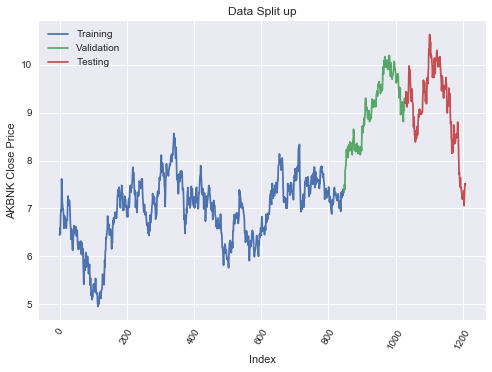

In [91]:
plt.plot(orig_df2_before_train["Close_stock"][0:train_len])
plt.plot(orig_df2_before_train["Close_stock"][train_len+1:train_len+val_len])
plt.plot(orig_df2_before_train["Close_stock"][train_len+val_len+1:])
plt.legend(['Training', 'Validation', 'Testing'], loc='upper left')
plt.title("Data Split up")
plt.xticks(rotation=60)
plt.ylabel("AKBNK Close Price")
plt.xlabel("Index")




### Scikit - Learn Machine Learning algorithms

In [93]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import fbeta_score

def train_and_predict(clf, X_train, y_train, X_test, y_test , params=None):
    """ Traing classifier and make score on predictions"""
    print("Training classifier: {}".format(clf))
    clf = clf.fit(X_train, y_train)
    return predict_labels(clf,X_test,y_test) 



def predict_labels(clf, X_test,y_test):
    print("Predicting Test")
    predictions= clf.predict(X_test)
    clf_rep = classification_report(y_test,predictions)
    f1 = f1_score(y_test, predictions, average='weighted')
    fbeta= fbeta_score(y_test, predictions, 0.5 ,average='weighted')
    acc_score = accuracy_score(y_test,predictions)
    print("Scores:")
    print(clf_rep)
    print("F1 Score: ", f1)
    print("F0.5 Score:", fbeta)
    print("Accuracy Score: ",acc_score)
    
    return (predictions, clf_rep,f1,fbeta,acc_score)
    
  



#### Benchmark is all increase, which can be made with a dummy classifier

In [94]:
#dummy classifier (buy and hold benchmark)
from sklearn.dummy import DummyClassifier

print("Benchmark - All buy")
#train a dummy classifier to make predictions to always buy (always 1)
dummy_classifier = DummyClassifier(strategy="constant", constant=1)
out = train_and_predict(dummy_classifier, X_train, y_train, X_test, y_test)



Benchmark - All buy
Training classifier: DummyClassifier(constant=1, random_state=None, strategy='constant')
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        93
          1       0.49      1.00      0.66        89

avg / total       0.24      0.49      0.32       182

F1 Score:  0.32119540975629535
F0.5 Score: 0.2663523746755081
Accuracy Score:  0.489010989010989


/Users/gorkemgoknar/Documents/anaconda3/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/gorkemgoknar/Documents/anaconda3/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [95]:
#alternative benchmark K-Nearest neighborhood
from sklearn.neighbors import KNeighborsClassifier
print("K neares neighboarhood")
knb  = KNeighborsClassifier()
out = train_and_predict(knb, X_train, y_train, X_test, y_test)



K neares neighboarhood
Training classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.55      0.56      0.56        93
          1       0.53      0.53      0.53        89

avg / total       0.54      0.54      0.54       182

F1 Score:  0.5438871530596356
F0.5 Score: 0.5438615772152171
Accuracy Score:  0.5439560439560439


#### Calculating Learning Algorithm performances

In [96]:
from sklearn.naive_bayes import GaussianNB
print("Gaussian Naive Bayes")
gnb  = GaussianNB()
out = train_and_predict(gnb, X_train, y_train, X_test, y_test)



Gaussian Naive Bayes
Training classifier: GaussianNB(priors=None)
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.52      0.49      0.51        93
          1       0.50      0.53      0.51        89

avg / total       0.51      0.51      0.51       182

F1 Score:  0.5109151935526358
F0.5 Score: 0.5112412656812801
Accuracy Score:  0.510989010989011


In [97]:
from sklearn.naive_bayes import MultinomialNB
print("Multinomial Naive Bayes")
mnb  = MultinomialNB()
out = train_and_predict(mnb, X_train, y_train, X_test, y_test)



Multinomial Naive Bayes
Training classifier: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.67      0.46      0.55        93
          1       0.58      0.76      0.66        89

avg / total       0.63      0.61      0.60       182

F1 Score:  0.6011873907193762
F0.5 Score: 0.6111629535698304
Accuracy Score:  0.6098901098901099


In [98]:
from sklearn import linear_model, datasets
print("Linear Regression")
logreg = linear_model.LogisticRegression(C=1e5)
out = train_and_predict(logreg, X_train, y_train, X_test, y_test)






Linear Regression
Training classifier: LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.66      0.38      0.48        93
          1       0.55      0.80      0.65        89

avg / total       0.61      0.58      0.56       182

F1 Score:  0.5635248250555527
F0.5 Score: 0.5801307485361137
Accuracy Score:  0.5824175824175825


In [99]:
from sklearn.ensemble import RandomForestClassifier
print("Random Forest ")
ranf  = RandomForestClassifier()
out = train_and_predict(ranf, X_train, y_train, X_test, y_test)




Random Forest 
Training classifier: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.49      0.65      0.56        93
          1       0.45      0.30      0.36        89

avg / total       0.47      0.48      0.46       182

F1 Score:  0.46242862802875295
F0.5 Score: 0.46450775210800116
Accuracy Score:  0.47802197802197804


In [100]:
from sklearn.svm import SVC
print("Support Vector ")
svc = SVC()
out = train_and_predict(svc, X_train, y_train, X_test, y_test)




Support Vector 
Training classifier: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.62      0.67      0.64        93
          1       0.62      0.57      0.60        89

avg / total       0.62      0.62      0.62       182

F1 Score:  0.6199945859067757
F0.5 Score: 0.6203470453692993
Accuracy Score:  0.6208791208791209


In [101]:
from sklearn.ensemble import GradientBoostingClassifier
print("Gradient boost ")
gra  = GradientBoostingClassifier()
out = train_and_predict(gra, X_train, y_train, X_test, y_test)



Gradient boost 
Training classifier: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.66      0.45      0.54        93
          1       0.57      0.75      0.65        89

avg / total       0.61      0.60      0.59       182

F1 Score:  0.5899532327114714
F0.5 Score: 0.5994838073887458
Accuracy Score:  0.5989010989010989


### Find Classifier with best accuracy

In [102]:
##Find best classifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

classifiers= []

gnb  = GaussianNB()
classifiers.append(gnb)

mnb  = MultinomialNB()
classifiers.append(mnb)

svc = SVC()
classifiers.append(svc)

knb  = KNeighborsClassifier()
classifiers.append(knb)

rnf = RandomForestClassifier()
classifiers.append(rnf)


gra  = GradientBoostingClassifier()
classifiers.append(gra)



#reset scores
f1_best= None
fbeta05_best = None
acc_score_best = None
best_classifier = None

for clf in classifiers:
    print("-"*30)
    print("Classifier:",clf)
    predictions, clf_rep,f1_this,fbeta05_this,acc_score_this = train_and_predict(clf, X_train, y_train, X_test, y_test)
    #print("F1 Score      :",f1_this)
    #print("F0.5 Score    :",fbeta05_this)
    #print("Accuracy Score:",acc_score_this)
    
    #get classifier with best accuracy
    if acc_score_best is None:
        print("Init")
        print("CLF:{} accuracy is : {}".format(clf,acc_score_this))
        acc_score_best =acc_score_this
        fbeta_best = fbeta05_this
        f1_best = f1_this
        best_classifier = clf
    elif acc_score_this> acc_score_best:
        print("Found better classifier")
        print("CLF:{} accuracy is : {}".format(clf,acc_score_this))
        acc_score_best =acc_score_this
        fbeta_best = fbeta05_this
        f1_best = f1_this
        best_classifier = clf
    
    
print("="*30)
print("Best classifer with default parameters is: ", best_classifier)




------------------------------
Classifier: GaussianNB(priors=None)
Training classifier: GaussianNB(priors=None)
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.52      0.49      0.51        93
          1       0.50      0.53      0.51        89

avg / total       0.51      0.51      0.51       182

F1 Score:  0.5109151935526358
F0.5 Score: 0.5112412656812801
Accuracy Score:  0.510989010989011
Init
CLF:GaussianNB(priors=None) accuracy is : 0.510989010989011
------------------------------
Classifier: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Training classifier: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.67      0.46      0.55        93
          1       0.58      0.76      0.66        89

avg / total       0.63      0.61      0.60       182

F1 Score:  0.6011873907193762
F0.5 Score: 0.6111629535698304
Accura

Best classifer with default parameters is:  SVC

#### Check if less features give better performance

In [103]:
#Trying to see if some features give better results
#Note that before this advanced technical indicators for foreign exchanges were used but it just made results worse

from sklearn.metrics import classification_report,confusion_matrix


filter_stock = [col for col in df2 if col.endswith('_stock')]
filter_usd = [col for col in df2 if col.endswith('_usd')]
filter_bist = [col for col in df2 if col.endswith('_bist30')]
filter_bry = [col for col in df2 if col.endswith('_bry')]


print("stock only")
print("Used features:",X_train[[*filter_stock]].columns)
clf = SVC()
out_stock_clf = train_and_predict(clf, X_train[[*filter_stock]], y_train, X_test[[*filter_stock]], y_test)

print("stock+usd")
print("Used features:",X_train[[*filter_stock,*filter_usd]].columns)
clf = SVC()
out_stock_clf_usd = train_and_predict(clf, X_train[[*filter_stock,*filter_usd]], y_train, X_test[[*filter_stock,*filter_usd]], y_test)

print("stock+usd+bist")
print("Used features:",X_train[[*filter_stock, *filter_usd,*filter_bist]].columns)

clf = SVC()
out_stock_clf_bist = train_and_predict(clf, X_train[[*filter_stock, *filter_usd,*filter_bist]], y_train, 
                        X_test[[*filter_stock, *filter_usd,*filter_bist]], y_test)

print("all_features")
print("Used features:",X_train.columns)


clf = SVC()
out_stock_clf_all = train_and_predict(clf, X_train, y_train, 
                        X_test, y_test)



stock only
Used features: Index(['High_Close_perc_stock', 'Prev_Day_Close_perc_stock', 'RSI_indicator_stock', 'CCI_indicator_stock', 'MACD_Signal_stock', 'EMA_F_indicator_stock', 'EMA_S_indicator_stock'], dtype='object')
Training classifier: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.62      0.62      0.62        93
          1       0.60      0.60      0.60        89

avg / total       0.61      0.61      0.61       182

F1 Score:  0.6098311791233028
F0.5 Score: 0.6098134951318016
Accuracy Score:  0.6098901098901099
stock+usd
Used features: Index(['High_Close_perc_stock', 'Prev_Day_Close_perc_stock', 'RSI_indicator_stock', 'CCI_indicator_stock', 'MACD_Signal_stock', 'EMA_F_indicator_stock', 'EMA_S_indicator_st

In [104]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


    

In [105]:
#OPTIMIZE SVC using Grid search
#Note that we use time series split to cross validate

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit

print("SVC Grid search - all features")
#svc grid search - all features 
num_features = X_train.shape[1]
param_grid = { 'kernel':('linear','rbf'), 
              'C':[0.2,0.5,1,2,3,7,10], 
              'gamma':[0.0015,0.015,0.15,0.1,0.5,0.3,0.001,1/num_features],
                }
                

# Initialize the classifier
clf = SVC(random_state=3)


# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {"recall","accuracy"}

# this is a timeseries validation should be done as it is else false grid search result will be shown
tscv = TimeSeriesSplit(n_splits=4)

#perform grid search
#Use accuracy and recall as score and refit to better accuracy, f1 score gives a lot of warning
grid = GridSearchCV(clf,param_grid,verbose=1,cv=tscv,  scoring=scoring,refit="accuracy")
# May take awhile!
grid.fit(X_train,y_train)

print("Best parameters and best estimator")
clf = grid.best_estimator_
print(grid.best_params_)
print(grid.best_estimator_)

grid_pred = predict_labels(clf,X_test,y_test)




SVC Grid search - all features
Fitting 4 folds for each of 112 candidates, totalling 448 fits
Best parameters and best estimator
{'C': 3, 'gamma': 0.017857142857142856, 'kernel': 'rbf'}
SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.017857142857142856,
  kernel='rbf', max_iter=-1, probability=False, random_state=3,
  shrinking=True, tol=0.001, verbose=False)
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.63      0.67      0.65        93
          1       0.63      0.60      0.61        89

avg / total       0.63      0.63      0.63       182

F1 Score:  0.6313667871335155
F0.5 Score: 0.6315242671215989
Accuracy Score:  0.6318681318681318


[Parallel(n_jobs=1)]: Done 448 out of 448 | elapsed:   22.8s finished


In [127]:
grid_results = pd.DataFrame.from_dict(grid.cv_results_)

/Users/gorkemgoknar/Documents/anaconda3/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_recall'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/gorkemgoknar/Documents/anaconda3/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_recall'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/gorkemgoknar/Documents/anaconda3/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_recall'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_scor

In [134]:
grid_results.sort_values(by="rank_test_accuracy")[["rank_test_accuracy","params","mean_test_recall","mean_train_recall","mean_test_accuracy"]]

,rank_test_accuracy,params,mean_test_recall,mean_train_recall,mean_test_accuracy
79,1,"{'C': 3, 'gamma': 0.017857142857142856, 'kerne...",0.572513,0.630474,0.591716
99,2,"{'C': 10, 'gamma': 0.015, 'kernel': 'rbf'}",0.558041,0.659462,0.590237
62,2,"{'C': 2, 'gamma': 0.017857142857142856, 'kerne...",0.524198,0.651713,0.590237
60,2,"{'C': 2, 'gamma': 0.001, 'kernel': 'linear'}",0.524198,0.651713,0.590237
58,2,"{'C': 2, 'gamma': 0.3, 'kernel': 'linear'}",0.524198,0.651713,0.590237
56,2,"{'C': 2, 'gamma': 0.5, 'kernel': 'linear'}",0.524198,0.651713,0.590237
54,2,"{'C': 2, 'gamma': 0.1, 'kernel': 'linear'}",0.524198,0.651713,0.590237
52,2,"{'C': 2, 'gamma': 0.15, 'kernel': 'linear'}",0.524198,0.651713,0.590237
50,2,"{'C': 2, 'gamma': 0.015, 'kernel': 'linear'}",0.524198,0.651713,0.590237
48,2,"{'C': 2, 'gamma': 0.0015, 'kernel': 'linear'}",0.524198,0.651713,0.590237


In [112]:
grid_results.plot(x="")

/Users/gorkemgoknar/Documents/anaconda3/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/gorkemgoknar/Documents/anaconda3/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_recall'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/gorkemgoknar/Documents/anaconda3/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_scor

{'mean_fit_time': array([0.01, 0.02, 0.01, 0.02, 0.01, 0.02, 0.01, 0.02, 0.01, 0.02, 0.01,
        0.02, 0.01, 0.01, 0.01, 0.02, 0.01, 0.02, 0.01, 0.02, 0.01, 0.02,
        0.01, 0.02, 0.01, 0.02, 0.01, 0.02, 0.01, 0.02, 0.01, 0.02, 0.02,
        0.02, 0.01, 0.02, 0.01, 0.02, 0.01, 0.02, 0.01, 0.02, 0.01, 0.02,
        0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
        0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.02, 0.02,
        0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02,
        0.02, 0.02, 0.02, 0.03, 0.02, 0.03, 0.02, 0.04, 0.02, 0.03, 0.02,
        0.03, 0.02, 0.03, 0.02, 0.03, 0.02, 0.03, 0.01, 0.04, 0.01, 0.04,
        0.02, 0.05, 0.02, 0.05, 0.02, 0.05, 0.02, 0.05, 0.02, 0.04, 0.02,
        0.05, 0.02]),
 'mean_score_time': array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01

[[62 31]
 [36 53]]
             precision    recall  f1-score   support

          0       0.63      0.67      0.65        93
          1       0.63      0.60      0.61        89

avg / total       0.63      0.63      0.63       182

Normalized confusion matrix
[[0.67 0.33]
 [0.4  0.6 ]]


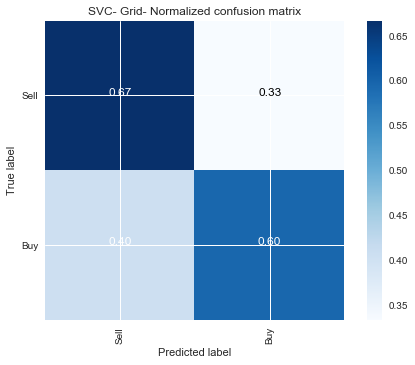

In [135]:
class_names = ["Sell","Buy"]
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,grid_pred[0])
print(cnf_matrix)
print(classification_report(y_test,grid_pred[0]))

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='SVC- Grid- Normalized confusion matrix')

plt.show()

In [139]:
##SHAP does not support SVC 

#import shap
# load JS visualization code to notebook
#shap.initjs()
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
#shap_values = shap.TreeExplainer(clf).shap_values(X_train)

# visualize the first prediction's explanation
#shap.force_plot(shap_values[0,:], X_train.iloc[0,:])

In [136]:
##Predict on real test data now
##TEST DATA WAS NOT USED IN TRAINING OR MODEL SELECTION
print("Predict final test data")
clf = grid.best_estimator_
final_prediction = predict_labels(clf,X_final_test,y_final_test)




Predict final test data
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.68      0.71      0.70       103
          1       0.59      0.56      0.58        78

avg / total       0.64      0.65      0.65       181

F1 Score:  0.6451238593721875
F0.5 Score: 0.6446559645801698
Accuracy Score:  0.6464088397790055


≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈
Standart Trading predictive strategy
First trade day: 2017-10-16 00:00:00
Last trade day: 2018-06-29 00:00:00
Number of trades: 68
Total money:  161.76063612801264
Increase %:  61.760636128012635
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈
BUY AND HOLD STRATEGY
First trade day: 2017-10-16 00:00:00
Last trade day: 2018-06-29 00:00:00
Number of trades: 1
Total money:  81.44792753473912
Increase %:  -18.552072465260878
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈
Standart Trading predictive strategy
First trade day: 2017-10-16 00:00:00
Last trade day: 2018-06-29 00:00:00
Number of trades: 87
!!!MONKEY TRADING!!! -random action 
This monkey gain %:  -24.482506613415595
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈
Standart Trading predictive strategy
First trade day: 2017-10-19 00:00:00
Last trade day: 2018-06-29 00:00:00
Number of trades: 100
!!!MONKEY TRADING!!! -random action 
This monkey gain %:  -23.19195042423449
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈
Standart Trading 

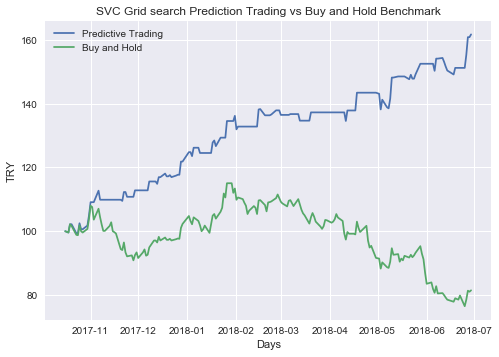

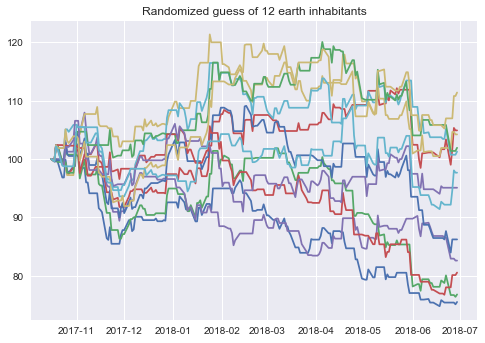

In [137]:
#Test found out result in simulation


prediction_to_use = np.array(final_prediction[0])
date_start_index = train_len + val_len

###TODO THIS ONLY PREDICTION, should also take that days price !!
#Grid SVC simulation on test
input_money = 100
plt.figure()
day_worth_df=simulate_outcome(prediction_to_use,
                                     orig_df2_before_train[date_start_index:][["Next_day_prediction","Date","Close_stock"]],
                                     close_col="Close_stock",
                                     sell_all=True,buy_all=True,debug =False)


plt.plot(day_worth_df["Date"],day_worth_df["Worth"])

plt.title("SVC Grid search Prediction Trading vs Buy and Hold Benchmark")
##BUY and hold
input_money = 100
day_worth_df=simulate_outcome(prediction_to_use,orig_df2_before_train[date_start_index:][["Next_day_prediction","Date","Close_stock"]],close_col="Close_stock",sell_all=True,buy_all=True,debug =False, buy_and_hold=True)
plt.plot(day_worth_df["Date"],day_worth_df["Worth"])

plt.legend(['Predictive Trading', 'Buy and Hold'], loc='upper left')

plt.ylabel("TRY")
plt.xlabel("Days")



##12 monkeys
twelve_monkeys = []
total_monkey_calls = 12
for i in range(total_monkey_calls):
    input_money = 200
    monkey_trader = simulate_outcome(prediction_to_use,orig_df2_before_train[date_start_index:][["Next_day_prediction","Date","Close_stock"]],close_col="Close_stock",monkey_trading=True,sell_all=True,buy_all=True,debug =False)
    twelve_monkeys.append(monkey_trader)
    
plt.figure()
plt.title("Randomized guess of 12 earth inhabitants")


for i in range(len(twelve_monkeys)):
    plt.plot(twelve_monkeys[i]["Date"],twelve_monkeys[i]["Worth"] )  
#monkey_average = monkey_total/total_monkey_calls
#print("MONKEY AVERAGE = {}".format(monkey_average))



#### Reduced features - core Technical features for stock only
Surprisingly using only core features for stock gives a comparable performance 
Features are:

'High_Close_perc_stock'  : ratio between close and high in day

'Prev_Day_Close_perc_stock' : ratio between day and previous days close price 

'RSI_indicator_stock'  : RSI indicator (2 for sell, 1 for hold , 0 for buy)

'CCI_indicator_stock' : CCI Indicator

'MACD_Signal_stock'   : Moving average CD signal

'EMA_F_indicator_stock' : Exponential moving average - fast indicator

'EMA_S_indicator_stock' : Exponential moving average - slow indicator


In [167]:
##Optimized grid search with only *stock features 
#OPTIMIZE SVC using Grid search
#Note that we use time series split to cross validate
print("Using only * stock features")
print("Feature used: ", X_train[[*filter_stock]].columns)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit

#svc grid search - all features 
num_features = X_train[[*filter_stock]].shape[1]
param_grid = {'kernel':('linear', 'rbf'), 
              'C':[0.5,1,2,3,7,10], 
              #'gamma':[0.001,0.01,0.1,1/num_features, 0.2,0.5,0.9],
              'gamma':[0.0015,0.015,0.15,0.1,0.5,0.3,0.001,1/num_features],
              #'decision_function_shape':['ovo','ovr']
                }
                

# Initialize the classifier
clf = SVC(random_state=3)


# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {"recall","accuracy"}

# this is a timeseries validation should be done as it is else false grid search result will be shown
tscv = TimeSeriesSplit(n_splits=4)

#perform grid search
#Use accuracy and F1 as score and refit to better f1
grid = GridSearchCV(clf,param_grid,verbose=1,cv=tscv,  scoring=scoring,refit="accuracy")
# May take awhile!
grid.fit(X_train[[*filter_stock]],y_train)

print("Best parameters and best estimator")
clf = grid.best_estimator_
print(grid.best_params_)
print(grid.best_estimator_)

grid_pred = predict_labels(clf,X_test[[*filter_stock]],y_test)





Using only * stock features
Feature used:  Index(['High_Close_perc_stock', 'Prev_Day_Close_perc_stock', 'RSI_indicator_stock', 'CCI_indicator_stock', 'MACD_Signal_stock', 'EMA_F_indicator_stock', 'EMA_S_indicator_stock'], dtype='object')
Fitting 4 folds for each of 96 candidates, totalling 384 fits
Best parameters and best estimator
{'C': 0.5, 'gamma': 0.0015, 'kernel': 'linear'}
SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0015, kernel='linear',
  max_iter=-1, probability=False, random_state=3, shrinking=True,
  tol=0.001, verbose=False)
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.62      0.62      0.62        93
          1       0.60      0.60      0.60        89

avg / total       0.61      0.61      0.61       182

F1 Score:  0.6098311791233028
F0.5 Score: 0.6098134951318016
Accuracy Score:  0.6098901098901099


[Parallel(n_jobs=1)]: Done 384 out of 384 | elapsed:    5.7s finished


[[58 35]
 [36 53]]
             precision    recall  f1-score   support

          0       0.62      0.62      0.62        93
          1       0.60      0.60      0.60        89

avg / total       0.61      0.61      0.61       182

Normalized confusion matrix
[[0.62 0.38]
 [0.4  0.6 ]]


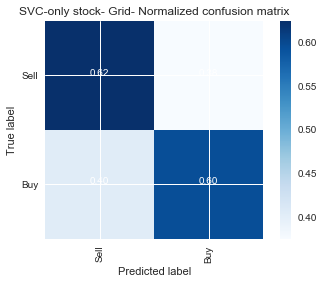

In [168]:
class_names = ["Sell","Buy"]
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,grid_pred[0])
print(cnf_matrix)
print(classification_report(y_test,grid_pred[0]))

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='SVC-only stock- Grid- Normalized confusion matrix')

plt.show()

Predict final test data
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.70      0.57      0.63       103
          1       0.55      0.68      0.61        78

avg / total       0.64      0.62      0.62       181

F1 Score:  0.6201125231609468
F0.5 Score: 0.6274604761480628
Accuracy Score:  0.6187845303867403
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈
Standart Trading predictive strategy
First trade day: 2017-10-16 00:00:00
Last trade day: 2018-06-29 00:00:00
Number of trades: 59
Total money:  137.8487195995312
Increase %:  37.848719599531194
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈
BUY AND HOLD STRATEGY
First trade day: 2017-10-16 00:00:00
Last trade day: 2018-06-29 00:00:00
Number of trades: 1
Total money:  81.44792753473911
Increase %:  -18.552072465260892
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈


'\n##12 monkeys\ntwelve_monkeys = []\ntotal_monkey_calls = 12\nfor i in range(total_monkey_calls):\n    input_money = 200\n    monkey_trader = simulate_outcome(prediction_to_use,orig_df2_before_train[train_len:][["Next_day_prediction_x","Date","Close_x"]],monkey_trading=True,sell_all=True,buy_all=True,debug =False)\n    twelve_monkeys.append(monkey_trader)\n    \n    \nplt.figure()\nfor i in range(len(twelve_monkeys)):\n    plt.plot(twelve_monkeys[i])  \n#monkey_average = monkey_total/total_monkey_calls\n#print("MONKEY AVERAGE = {}".format(monkey_average))\n'

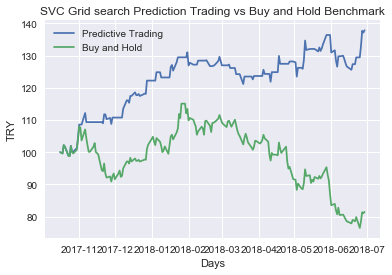

In [169]:
#Test found out result in simulation
#Using only * stock features
##Predict on real test data now
##TEST DATA WAS NOT USED IN TRAINING OR MODEL SELECTION
print("Predict final test data")
clf = grid.best_estimator_
final_prediction = predict_labels(clf,X_final_test[[*filter_stock]],y_final_test)

prediction_to_use = np.array(final_prediction[0])

date_start_index = train_len + val_len


###TODO THIS ONLY PREDICTION, should also take that days price !!
#Grid SVC simulation on test
input_money = 100
plt.figure()
day_worth_df=simulate_outcome(prediction_to_use,
                                     orig_df2_before_train[date_start_index:][["Next_day_prediction","Date","Close_stock"]],
                                     close_col="Close_stock",
                                     sell_all=True,buy_all=True,debug =False)


plt.plot(day_worth_df["Date"],day_worth_df["Worth"])

plt.title("SVC Grid search Prediction Trading vs Buy and Hold Benchmark")
##BUY and hold
input_money = 100
day_worth_df=simulate_outcome(prediction_to_use,orig_df2_before_train[date_start_index:][["Next_day_prediction","Date","Close_stock"]],close_col="Close_stock",sell_all=True,buy_all=True,debug =False, buy_and_hold=True)
plt.plot(day_worth_df["Date"],day_worth_df["Worth"])

plt.legend(['Predictive Trading', 'Buy and Hold'], loc='upper left')

plt.ylabel("TRY")
plt.xlabel("Days")


"""
##12 monkeys
twelve_monkeys = []
total_monkey_calls = 12
for i in range(total_monkey_calls):
    input_money = 200
    monkey_trader = simulate_outcome(prediction_to_use,orig_df2_before_train[train_len:][["Next_day_prediction_x","Date","Close_x"]],monkey_trading=True,sell_all=True,buy_all=True,debug =False)
    twelve_monkeys.append(monkey_trader)
    
    
plt.figure()
for i in range(len(twelve_monkeys)):
    plt.plot(twelve_monkeys[i])  
#monkey_average = monkey_total/total_monkey_calls
#print("MONKEY AVERAGE = {}".format(monkey_average))
"""




## Neural Network

In [177]:
##NN  
import numpy as np
from keras.layers import Conv1D,Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
import h5py
# For adding new activation function
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


class swish_a(Activation):
    
    def __init__(self, activation, **kwargs):
        super(swish_a, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'
        
def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': swish_a(swish)})


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.utils import np_utils



X_train_keras = X_train
X_test_keras = X_test

#X_train_keras = np.expand_dims(X_train[[*filter_stock]], axis=1)
#X_test_keras = np.expand_dims(X_test[[*filter_stock]], axis=1)

y_train_keras = to_categorical(y_train)
#y_train_keras = np.expand_dims(y_train_keras, axis=1)

y_test_keras = to_categorical(y_test)
#y_test_keras = np.expand_dims(y_test_keras

#Base Neural Network 
# 15 input, 5 hidden , 2 output


model = Sequential()
model.add(Dense(15, input_dim=X_train_keras.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5,  activation='relu'))
model.add(Dropout(0.1))
#model.add(Dense(neurons, activation='relu'))

#output
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

"""
#Test CNN
# Keras model with one Convolution1D layer
# unfortunately more number of covnolutional layers, filters and filters lenght 
# don't give better accuracy

X_train_keras = np.expand_dims(X_train, axis=1)
X_test_keras = np.expand_dims(X_test, axis=1)

y_train_keras = np_utils.to_categorical(y_train, 2)
y_train_keras = np.expand_dims(y_train_keras, axis=1)

y_test_keras = np_utils.to_categorical(y_test, 2)
y_test_keras = np.expand_dims(y_test_keras, axis=1)


model = Sequential()
model.add(Conv1D(filters=1024, kernel_size=1,  input_shape=(None,X_train_keras.shape[2])) )
#model.add(Dense(50, input_shape=(None,X_train_keras.shape[2])))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.1))
#model.add(Dense(32, activation='relu'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

"""

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_599 (Dense)            (None, 15)                855       
_________________________________________________________________
dropout_397 (Dropout)        (None, 15)                0         
_________________________________________________________________
dense_600 (Dense)            (None, 5)                 80        
_________________________________________________________________
dropout_398 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_601 (Dense)            (None, 2)                 12        
_________________________________________________________________
activation_200 (Activation)  (None, 2)                 0         
Total params: 947
Trainable params: 947
Non-trainable params: 0
_________________________________________________________________


"\n#Test CNN\n# Keras model with one Convolution1D layer\n# unfortunately more number of covnolutional layers, filters and filters lenght \n# don't give better accuracy\n\nX_train_keras = np.expand_dims(X_train, axis=1)\nX_test_keras = np.expand_dims(X_test, axis=1)\n\ny_train_keras = np_utils.to_categorical(y_train, 2)\ny_train_keras = np.expand_dims(y_train_keras, axis=1)\n\ny_test_keras = np_utils.to_categorical(y_test, 2)\ny_test_keras = np.expand_dims(y_test_keras, axis=1)\n\n\nmodel = Sequential()\nmodel.add(Conv1D(filters=1024, kernel_size=1,  input_shape=(None,X_train_keras.shape[2])) )\n#model.add(Dense(50, input_shape=(None,X_train_keras.shape[2])))\nmodel.add(Activation('relu'))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(20, activation='relu'))\n#model.add(Dense(128, activation='relu'))\n#model.add(Dropout(0.1))\n#model.add(Dense(32, activation='relu'))\nmodel.add(Dense(2))\nmodel.add(Activation('softmax'))\nmodel.summary()\n\n"

In [178]:
from keras.callbacks import ModelCheckpoint  
from keras.callbacks import EarlyStopping
from keras import optimizers

earlystopper = EarlyStopping(monitor='val_loss', patience=4, verbose=1)


#SGD -> gradient descent
#opt = optimizers.SGD(lr=0.01, nesterov=True, decay=1e-6, momentum=0.9)
epochs = 40
learning_rate = 0.02
decay_rate = learning_rate / epochs
momentum_val = 0.5
opt = optimizers.SGD(lr=learning_rate, momentum=momentum_val, decay=decay_rate, nesterov=True)



#opt = optimizers.SGD(lr=0.02, decay=1e-5, momentum=0.9, nesterov=True)
#opt = "nadam"
#opt = optimizers.SGD(lr=0.05)  # or adam
loss="categorical_crossentropy" # mean_squared_error for regression, crossentropy for class
model.compile(loss =loss , optimizer = opt,metrics=['acc', ])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

batch_size = 1
history = model.fit(X_train_keras, y_train_keras,  validation_split=0.1, epochs=epochs,  batch_size=batch_size ,  
                    callbacks=[], verbose=1)

print (model.summary())
 
score_train = model.evaluate (X_train_keras, y_train_keras, batch_size =batch_size)
score_test = model.evaluate (X_test_keras, y_test_keras, batch_size =batch_size)
print ("score in train  = ", score_train ) 
print ("score in test  = ", score_test )







Train on 761 samples, validate on 85 samples
Epoch 1/20
761/761 [==============================] - 9s 12ms/step - loss: 0.6991 - acc: 0.5217 - val_loss: 0.6875 - val_acc: 0.5529
Epoch 2/20
761/761 [==============================] - 2s 3ms/step - loss: 0.6926 - acc: 0.5243 - val_loss: 0.6888 - val_acc: 0.5294
Epoch 3/20
761/761 [==============================] - 2s 3ms/step - loss: 0.6931 - acc: 0.5151 - val_loss: 0.6837 - val_acc: 0.5529
Epoch 4/20
761/761 [==============================] - 2s 3ms/step - loss: 0.6865 - acc: 0.5572 - val_loss: 0.6879 - val_acc: 0.5294
Epoch 5/20
761/761 [==============================] - 2s 3ms/step - loss: 0.6860 - acc: 0.5545 - val_loss: 0.6819 - val_acc: 0.5765
Epoch 6/20
761/761 [==============================] - 2s 3ms/step - loss: 0.6782 - acc: 0.5716 - val_loss: 0.6704 - val_acc: 0.5647
Epoch 7/20
761/761 [==============================] - 2s 3ms/step - loss: 0.6709 - acc: 0.5861 - val_loss: 0.6764 - val_acc: 0.5765
Epoch 8/20
761/761 [==========

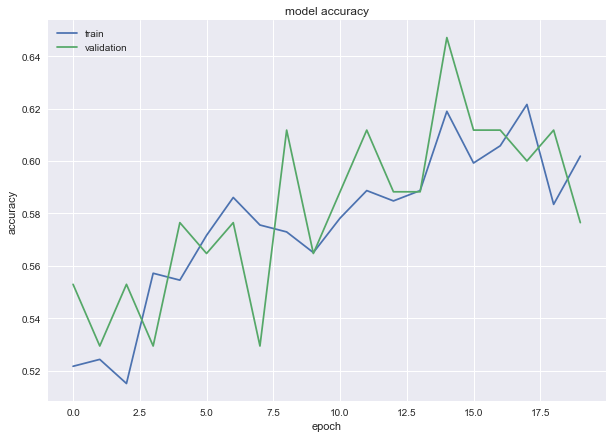

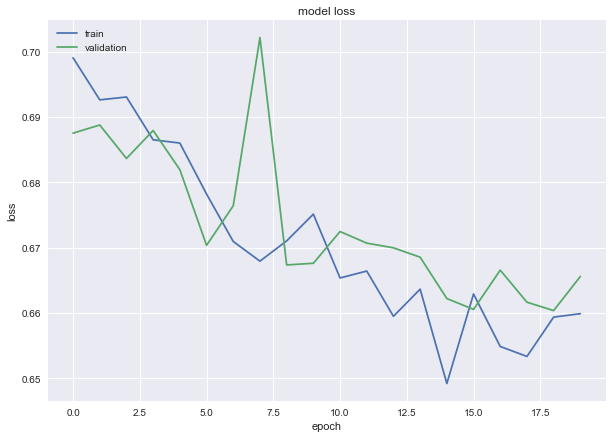

In [179]:
# list all data in history
#print(history.history.keys())
# summarize history for accuracy
plt.rcParams["figure.figsize"] = (10,7)

acc = "acc"
acc_val = "val_" + acc 
plt.plot(history.history[acc])
plt.plot(history.history[acc_val])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [181]:
pred_cnn

array([0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1])

Neural Network

Classification Report:
              precision    recall  f1-score   support

          0       0.62      0.76      0.68        93
          1       0.67      0.51      0.58        89

avg / total       0.64      0.64      0.63       182

F1 Score:  0.6309699915469147
F0.5 Score: 0.6362311234133381
Accuracy Score:  0.6373626373626373
Normalized confusion matrix
[[0.76 0.24]
 [0.49 0.51]]


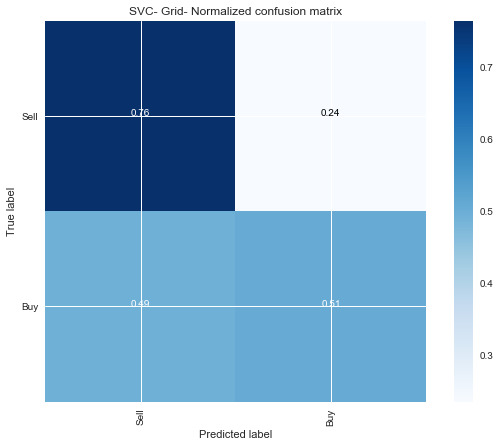

In [182]:
pred_cnn = model.predict_classes(X_test_keras) 
#prediction_to_use = [e[0] for e in pred_cnn.tolist()]
prediction_to_use = pred_cnn
print("Neural Network\n")
#clf_rep = classification_report(y_test,prediction_to_use)
f1 = f1_score(y_test, prediction_to_use, average='weighted')
fbeta= fbeta_score(y_test, prediction_to_use, 0.5 ,average='weighted')
acc_score = accuracy_score(y_test,prediction_to_use)

class_names = ["Sell","Buy"]
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,prediction_to_use)
print("Classification Report:\n",classification_report(y_test,prediction_to_use))
print("F1 Score: ", f1)
print("F0.5 Score:", fbeta)
print("Accuracy Score: ",acc_score)

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='SVC- Grid- Normalized confusion matrix')

plt.show()

In [82]:
##GET TEST TRAIN split
"""
X = df2
y = target_next_day

train_percent = 85

X_train, X_test, y_train, y_test = split_train_test(X,y,percent=train_percent)   

train_len = round((train_percent/100) * len(X))
"""



'\nX = df2\ny = target_next_day\n\ntrain_percent = 85\n\nX_train, X_test, y_train, y_test = split_train_test(X,y,percent=train_percent)   \n\ntrain_len = round((train_percent/100) * len(X))\n'

#### Calculating Learning Algorithm performances 
### USING GRID SEARCH ON Neural Network

In [92]:
#grid search on neural network
print("Grid search on neural network")

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from datetime import datetime


#from IPython.parallel import Client

X_train_keras = X_train
X_test_keras = X_test

#X_train_keras = np.expand_dims(X_train[[*filter_stock]], axis=1)
#X_test_keras = np.expand_dims(X_test[[*filter_stock]], axis=1)

y_train_keras = to_categorical(y_train)
#y_train_keras = np.expand_dims(y_train_keras, axis=1)

y_test_keras = to_categorical(y_test)
#y_test_keras = np.expand_dims(y_test_keras, axis=1)

#print(X_train_keras.shape)
#print(y_train_keras.shape)

# Function to create model, required for KerasClassifier
def create_model(optimizer='adam',learn_rate=0.01, momentum=0.1,neurons=1):
    # create model
    model = Sequential()
    model.add(Dense(neurons*3, input_dim=X_train_keras.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(neurons,  activation='relu'))
    model.add(Dropout(0.1))
    #model.add(Dense(neurons, activation='relu'))
    
    #output
    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    
    # Compile model
    #model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters

#batch_size = [1,5]
batch_size = [1,5]
epochs = [10,20,50,100]
#epochs = [5,10,20,50,100]
optimizer = ['SGD']
#learn_rate = [0.01, 0.02,0.1,0.2,0.3]
learn_rate = [0.02,0.1]
momentum = [0.5,0.8]
#neurons = [10]
neurons = [5,10,20,50]

# this is a timeseries validation should be done as it is else false grid search result will be shown
tscv = TimeSeriesSplit(n_splits=3)

scoring = {"recall","accuracy"}

print("This will take long time")

param_grid = dict(neurons=neurons, epochs=epochs, optimizer=optimizer,learn_rate=learn_rate, momentum=momentum)

#error when using scorer
#grid = GridSearchCV(estimator=model, param_grid=param_grid,verbose=1, n_jobs=1,scoring=scoring, 
#                    cv=tscv, refit="accuracy")
print("Start search:", str(datetime.now()))

gridnn = GridSearchCV(estimator=model, param_grid=param_grid,verbose=50, n_jobs=1, 
                    cv=tscv)

print("End search:", str(datetime.now()))


nn_grid_result = gridnn.fit(X_train_keras, y_train_keras )

# summarize results
print("Best: %f using %s" % (nn_grid_result.best_score_, nn_grid_result.best_params_))
means = nn_grid_result.cv_results_['mean_test_score']
stds = nn_grid_result.cv_results_['std_test_score']
params = nn_grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
print("Done....")

Grid search on neural network
This will take long time
Start search: 2018-07-01 17:58:34.972687
End search: 2018-07-01 17:58:34.973242
Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] epochs=10, learn_rate=0.02, momentum=0.5, neurons=5, optimizer=SGD 
[CV]  epochs=10, learn_rate=0.02, momentum=0.5, neurons=5, optimizer=SGD, score=0.4691943136436679, total=   0.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[CV] epochs=10, learn_rate=0.02, momentum=0.5, neurons=5, optimizer=SGD 
[CV]  epochs=10, learn_rate=0.02, momentum=0.5, neurons=5, optimizer=SGD, score=0.4597156395279401, total=   1.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[CV] epochs=10, learn_rate=0.02, momentum=0.5, neurons=5, optimizer=SGD 
[CV]  epochs=10, learn_rate=0.02, momentum=0.5, neurons=5, optimizer=SGD, score=0.5639810443489472, total=   1.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[C

[CV]  epochs=10, learn_rate=0.1, momentum=0.5, neurons=20, optimizer=SGD, score=0.535545023414196, total=   1.9s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:   44.4s remaining:    0.0s
[CV] epochs=10, learn_rate=0.1, momentum=0.5, neurons=20, optimizer=SGD 
[CV]  epochs=10, learn_rate=0.1, momentum=0.5, neurons=20, optimizer=SGD, score=0.5023696692351481, total=   2.1s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:   46.5s remaining:    0.0s
[CV] epochs=10, learn_rate=0.1, momentum=0.5, neurons=20, optimizer=SGD 
[CV]  epochs=10, learn_rate=0.1, momentum=0.5, neurons=20, optimizer=SGD, score=0.5497630348702742, total=   2.1s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   48.7s remaining:    0.0s
[CV] epochs=10, learn_rate=0.1, momentum=0.5, neurons=50, optimizer=SGD 
[CV]  epochs=10, learn_rate=0.1, momentum=0.5, neurons=50, optimizer=SGD, score=0.5165876794200372, total=   2.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   50.6s remaining:    0.0s
[CV] e

[CV]  epochs=20, learn_rate=0.02, momentum=0.8, neurons=20, optimizer=SGD, score=0.5450236944225727, total=   3.3s
[CV] epochs=20, learn_rate=0.02, momentum=0.8, neurons=20, optimizer=SGD 
[CV]  epochs=20, learn_rate=0.02, momentum=0.8, neurons=20, optimizer=SGD, score=0.5924170613288879, total=   3.6s
[CV] epochs=20, learn_rate=0.02, momentum=0.8, neurons=20, optimizer=SGD 
[CV]  epochs=20, learn_rate=0.02, momentum=0.8, neurons=20, optimizer=SGD, score=0.5402843613195193, total=   3.7s
[CV] epochs=20, learn_rate=0.02, momentum=0.8, neurons=50, optimizer=SGD 
[CV]  epochs=20, learn_rate=0.02, momentum=0.8, neurons=50, optimizer=SGD, score=0.5497630348702742, total=   3.4s
[CV] epochs=20, learn_rate=0.02, momentum=0.8, neurons=50, optimizer=SGD 
[CV]  epochs=20, learn_rate=0.02, momentum=0.8, neurons=50, optimizer=SGD, score=0.5450236963999779, total=   3.7s
[CV] epochs=20, learn_rate=0.02, momentum=0.8, neurons=50, optimizer=SGD 
[CV]  epochs=20, learn_rate=0.02, momentum=0.8, neurons

[CV]  epochs=50, learn_rate=0.02, momentum=0.8, neurons=5, optimizer=SGD, score=0.549763032892869, total=   7.0s
[CV] epochs=50, learn_rate=0.02, momentum=0.8, neurons=10, optimizer=SGD 
[CV]  epochs=50, learn_rate=0.02, momentum=0.8, neurons=10, optimizer=SGD, score=0.48341232199239503, total=   5.7s
[CV] epochs=50, learn_rate=0.02, momentum=0.8, neurons=10, optimizer=SGD 
[CV]  epochs=50, learn_rate=0.02, momentum=0.8, neurons=10, optimizer=SGD, score=0.5687203802768653, total=   6.4s
[CV] epochs=50, learn_rate=0.02, momentum=0.8, neurons=10, optimizer=SGD 
[CV]  epochs=50, learn_rate=0.02, momentum=0.8, neurons=10, optimizer=SGD, score=0.5545023706569491, total=   6.9s
[CV] epochs=50, learn_rate=0.02, momentum=0.8, neurons=20, optimizer=SGD 
[CV]  epochs=50, learn_rate=0.02, momentum=0.8, neurons=20, optimizer=SGD, score=0.5639810443489472, total=   5.9s
[CV] epochs=50, learn_rate=0.02, momentum=0.8, neurons=20, optimizer=SGD 
[CV]  epochs=50, learn_rate=0.02, momentum=0.8, neurons=

[CV]  epochs=100, learn_rate=0.02, momentum=0.5, neurons=50, optimizer=SGD, score=0.5687203801356221, total=   9.3s
[CV] epochs=100, learn_rate=0.02, momentum=0.5, neurons=50, optimizer=SGD 
[CV]  epochs=100, learn_rate=0.02, momentum=0.5, neurons=50, optimizer=SGD, score=0.6303317512946106, total=  10.7s
[CV] epochs=100, learn_rate=0.02, momentum=0.8, neurons=5, optimizer=SGD 
[CV]  epochs=100, learn_rate=0.02, momentum=0.8, neurons=5, optimizer=SGD, score=0.5592417078560562, total=   7.9s
[CV] epochs=100, learn_rate=0.02, momentum=0.8, neurons=5, optimizer=SGD 
[CV]  epochs=100, learn_rate=0.02, momentum=0.8, neurons=5, optimizer=SGD, score=0.488151658485286, total=   9.1s
[CV] epochs=100, learn_rate=0.02, momentum=0.8, neurons=5, optimizer=SGD 
[CV]  epochs=100, learn_rate=0.02, momentum=0.8, neurons=5, optimizer=SGD, score=0.5118483415147139, total=  10.6s
[CV] epochs=100, learn_rate=0.02, momentum=0.8, neurons=10, optimizer=SGD 
[CV]  epochs=100, learn_rate=0.02, momentum=0.8, neu

In [171]:
#Best: 0.605263 using {'epochs': 100, 'learn_rate': 0.01, 'momentum': 0.5, 'neurons': 10, 'optimizer': 'SGD'}   
print("Best parameters and best estimator")
clf = nn_grid_result.best_estimator_
print(nn_grid_result.best_params_)
print(nn_grid_result.best_estimator_)

grid_pred = predict_labels(clf,X_test_keras,y_test)



Best parameters and best estimator
{'epochs': 100, 'learn_rate': 0.1, 'momentum': 0.5, 'neurons': 50, 'optimizer': 'SGD'}
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.64      0.74      0.69        93
          1       0.68      0.57      0.62        89

avg / total       0.66      0.66      0.66       182

F1 Score:  0.6567233985526669
F0.5 Score: 0.6589307450317274
Accuracy Score:  0.6593406593406593


Neural Network

Classification Report:
              precision    recall  f1-score   support

          0       0.64      0.74      0.69        93
          1       0.68      0.57      0.62        89

avg / total       0.66      0.66      0.66       182

F1 Score:  0.6567233985526669
F0.5 Score: 0.6589307450317274
Accuracy Score:  0.6593406593406593
Normalized confusion matrix
[[0.74 0.26]
 [0.43 0.57]]


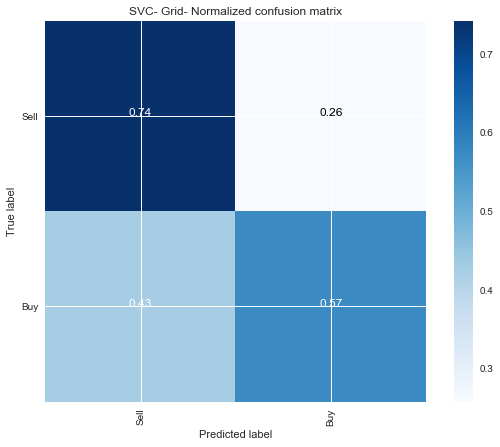

In [96]:
prediction_to_use = grid_pred[0]

print("Neural Network\n")
#clf_rep = classification_report(y_test,prediction_to_use)
f1 = f1_score(y_test, prediction_to_use, average='weighted')
fbeta= fbeta_score(y_test, prediction_to_use, 0.5 ,average='weighted')
acc_score = accuracy_score(y_test,prediction_to_use)

class_names = ["Sell","Buy"]
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,prediction_to_use)
print("Classification Report:\n",classification_report(y_test,prediction_to_use))
print("F1 Score: ", f1)
print("F0.5 Score:", fbeta)
print("Accuracy Score: ",acc_score)

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='SVC- Grid- Normalized confusion matrix')

plt.show()

{'epochs': 100, 'learn_rate': 0.1, 'momentum': 0.5, 'neurons': 50, 'optimizer': 'SGD'}
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.67      0.64      0.66       103
          1       0.55      0.59      0.57        78

avg / total       0.62      0.62      0.62       181

F1 Score:  0.6199625393160481
F0.5 Score: 0.6211202443516147
Accuracy Score:  0.6187845303867403
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈
Standart Trading predictive strategy
First trade day: 2017-10-16 00:00:00
Last trade day: 2018-06-29 00:00:00
Number of trades: 73
Total money:  145.1045638526466
Increase %:  45.104563852646606
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈
BUY AND HOLD STRATEGY
First trade day: 2017-10-16 00:00:00
Last trade day: 2018-06-29 00:00:00
Number of trades: 1
Total money:  81.44792753473911
Increase %:  -18.552072465260892
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈


'\n##12 monkeys\ntwelve_monkeys = []\ntotal_monkey_calls = 12\nfor i in range(total_monkey_calls):\n    input_money = 200\n    monkey_trader = simulate_outcome(prediction_to_use,orig_df2_before_train[train_len:][["Next_day_prediction_x","Date","Close_x"]],monkey_trading=True,sell_all=True,buy_all=True,debug =False)\n    twelve_monkeys.append(monkey_trader)\n    \nplt.figure()\nfor i in range(len(twelve_monkeys)):\n    plt.plot(twelve_monkeys[i])  \n#monkey_average = monkey_total/total_monkey_calls\n#print("MONKEY AVERAGE = {}".format(monkey_average))\n'

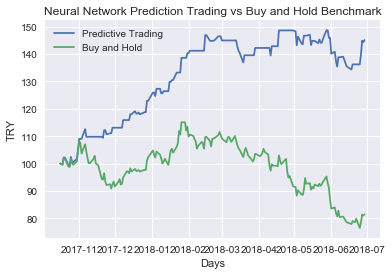

In [170]:
#Simulate neural network 
clf = nn_grid_result.best_estimator_
print(nn_grid_result.best_params_)
print(nn_grid_result.best_estimator_)

final_test_pred = predict_labels(clf,X_final_test,y_final_test)
prediction_to_use = final_test_pred[0]
day_start= train_len+val_len


input_money = 100
plt.figure()
day_worth_df=simulate_outcome(prediction_to_use,
                                     orig_df2_before_train[day_start:][["Next_day_prediction","Date","Close_stock"]],
                                     close_col="Close_stock",
                                     sell_all=True,buy_all=True,debug =False)


plt.plot(day_worth_df["Date"],day_worth_df["Worth"])

plt.title("Neural Network Prediction Trading vs Buy and Hold Benchmark")
##BUY and hold
input_money = 100
day_worth_df=simulate_outcome(prediction_to_use,orig_df2_before_train[day_start:][["Next_day_prediction","Date","Close_stock"]],close_col="Close_stock",sell_all=True,buy_all=True,debug =False, buy_and_hold=True)
plt.plot(day_worth_df["Date"],day_worth_df["Worth"])

plt.legend(['Predictive Trading', 'Buy and Hold'], loc='upper left')

plt.ylabel("TRY")
plt.xlabel("Days")


"""
##12 monkeys
twelve_monkeys = []
total_monkey_calls = 12
for i in range(total_monkey_calls):
    input_money = 200
    monkey_trader = simulate_outcome(prediction_to_use,orig_df2_before_train[train_len:][["Next_day_prediction_x","Date","Close_x"]],monkey_trading=True,sell_all=True,buy_all=True,debug =False)
    twelve_monkeys.append(monkey_trader)
    
plt.figure()
for i in range(len(twelve_monkeys)):
    plt.plot(twelve_monkeys[i])  
#monkey_average = monkey_total/total_monkey_calls
#print("MONKEY AVERAGE = {}".format(monkey_average))
"""





### Alternative automated stock simulations 
Using only core TA features for stock (predict_stock)
Note that only Train - Test split is done, crossvalidation is done at grid search while selecting model

In [125]:
from evaluate_model import * 

#Target 2 - THYAO - Turkish Airlines - global
thyao_df_base = get_stock_from_mynet("THYAO",stock_range="yillik_5") #69,66% in year
#ttrak_df_base = get_stock_from_mynet("TTRAK",stock_range="yillik_5") #-32,70% in year

#Target 3 - TUPRS - Tüpraş - Responsible for oil price in Turkey
tuprs_df = get_stock_from_mynet("TUPRS",stock_range="yillik_5")

#Telekom - Turkcell
#tcell_df_base = get_stock_from_mynet("TCELL",stock_range="yillik_5") # 11.08% in year

#Telekom - Alcatel (now Nokia)
#alctl_df_base = get_stock_from_mynet("ALCTL",stock_range="yillik_5") #-52,91% in year

#Automotive
#asuzu_df_base = get_stock_from_mynet("ASUZU",stock_range="yillik_5") #-52,91% in year
#toaso_df = get_stock_from_mynet("TOASO",stock_range="yillik_5")



http://finans.mynet.com/borsa/ajaxCharts/?type=stock&ticker=THYAO&range=5y
Stock: THYAO
http://finans.mynet.com/borsa/ajaxCharts/?type=stock&ticker=TUPRS&range=5y
Stock: TUPRS


In [ ]:
# THYAO - Turkish Airlines

Generating stock features for:  THYAO
Getting google trends for keywords: faiz
2017-03-29 2017-12-23
2016-08-11 2017-05-07
2015-12-25 2016-09-19
2015-05-09 2016-02-02
2014-09-21 2015-06-17
2014-02-03 2014-10-30
2013-06-18 2014-03-14
2012-10-31 2013-07-27
2012-07-03 2012-12-09
http://finans.mynet.com/borsa/ajaxCharts/?type=index&ticker=XU030&range=5y
Stock: BIST 30
BIST30 shape (1238, 5)
BIST30 Columns:
 Index(['Date', 'High', 'Low', 'Volume', 'Close'], dtype='object')
http://finans.mynet.com/doviz/ajaxCharts/?doviz=USD&market=freeMarket&period=5y
Stock: USD
USD/TRY Columns:
 Index(['Exchange', 'Date', 'High', 'Low', 'Close'], dtype='object')
http://finans.mynet.com/doviz/ajaxCharts/?doviz=RUB&market=freeMarket&period=5y
Stock: RUB
http://finans.mynet.com/doviz/ajaxCharts/?doviz=BRL&market=freeMarket&period=5y
Stock: BRL
http://finans.mynet.com/doviz/ajaxCharts/?doviz=JPY&market=freeMarket&period=5y
Stock: JPY
Generating Bist30 features
Generating exchange features
Base Stock shape: (12

/Users/gorkemgoknar/Documents/anaconda3/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/gorkemgoknar/Desktop/udacity_capstone/capstone_module.py:370: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_train[column] = normalize_series( X_train[column] )



normalizing test


/Users/gorkemgoknar/Desktop/udacity_capstone/capstone_module.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_test[column] = normalize_series( X_test[column] )


Best parameters and best estimator
{'C': 10, 'gamma': 0.017857142857142856, 'kernel': 'rbf', 'shrinking': False}
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.017857142857142856,
  kernel='rbf', max_iter=-1, probability=False, random_state=31,
  shrinking=False, tol=0.001, verbose=False)
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.65      0.66      0.66        94
          1       0.63      0.62      0.62        87

avg / total       0.64      0.64      0.64       181

F1 Score:  0.6407961127087368
F0.5 Score: 0.6407621731588541
Accuracy Score:  0.6408839779005525
Scores:
             precision    recall  f1-score   support

          0       0.65      0.66      0.66        94
          1       0.63      0.62      0.62        87

avg / total       0.64      0.64      0.64       181

F1 Score:  0.6242774566473989
F0.5 Score: 0.6264501160092808
Accuracy Score:  0.64088397790

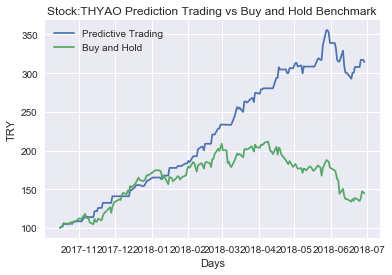

In [128]:
predict_stock(thyao_df_base,"THYAO",use_all_features=True)

In [ ]:
# TUPRAS - Energy Industry


Generating stock features for:  TUPRS
DF2 shape before Nan drop: (1243, 24)
DF2 shape (drop 20% nan colmns): (1243, 24)
DF2 shape after dropping na: (1213, 24)
DF2 shape after cleanup: (1212, 24)
original df2 copyied to orig_df2_before_train:
DF2 shape after final drop: (1212, 19)
normalizing train


/Users/gorkemgoknar/Documents/anaconda3/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/gorkemgoknar/Desktop/udacity_capstone/capstone_module.py:369: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_train[column] = normalize_series( X_train[column] )


normalizing test


/Users/gorkemgoknar/Desktop/udacity_capstone/capstone_module.py:375: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Best parameters and best estimator
{'C': 1, 'gamma': 0.15, 'kernel': 'rbf', 'shrinking': False}
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.15, kernel='rbf',
  max_iter=-1, probability=False, random_state=31, shrinking=False,
  tol=0.001, verbose=False)
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.64      0.55      0.59        99
          1       0.54      0.64      0.59        83

avg / total       0.60      0.59      0.59       182

F1 Score:  0.5880987050265196
F0.5 Score: 0.5920524121976029
Accuracy Score:  0.5879120879120879
Scores:
             precision    recall  f1-score   support

          0       0.64      0.55      0.59        99
          1       0.54      0.64      0.59        83

avg / total       0.60      0.59      0.59       182

F1 Score:  0.5856353591160222
F0.5 Score: 0.5578947368421053
Accuracy Score:  0.5879120879120879
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈
Standar

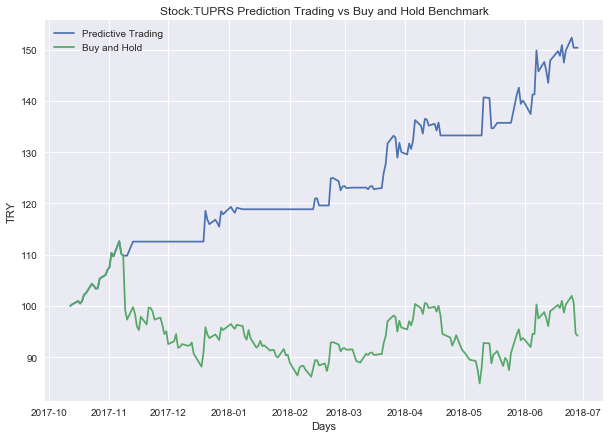

In [68]:
predict_stock(tuprs_df,"TUPRS",use_all_features=True)

http://finans.mynet.com/borsa/ajaxCharts/?type=stock&ticker=TCELL&range=5y
Stock: TCELL
Generating stock features for:  TCELL
Getting google trends for keywords: faiz
2017-03-29 2017-12-23
2016-08-11 2017-05-07
2015-12-25 2016-09-19
2015-05-09 2016-02-02
2014-09-21 2015-06-17
2014-02-03 2014-10-30
2013-06-18 2014-03-14
2012-10-31 2013-07-27
2012-07-03 2012-12-09
http://finans.mynet.com/borsa/ajaxCharts/?type=index&ticker=XU030&range=5y
Stock: BIST 30
BIST30 shape (1238, 5)
BIST30 Columns:
 Index(['Date', 'High', 'Low', 'Volume', 'Close'], dtype='object')
http://finans.mynet.com/doviz/ajaxCharts/?doviz=USD&market=freeMarket&period=5y
Stock: USD
USD/TRY Columns:
 Index(['Exchange', 'Date', 'High', 'Low', 'Close'], dtype='object')
http://finans.mynet.com/doviz/ajaxCharts/?doviz=RUB&market=freeMarket&period=5y
Stock: RUB
http://finans.mynet.com/doviz/ajaxCharts/?doviz=BRL&market=freeMarket&period=5y
Stock: BRL
http://finans.mynet.com/doviz/ajaxCharts/?doviz=JPY&market=freeMarket&period=5y


/Users/gorkemgoknar/Documents/anaconda3/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/gorkemgoknar/Desktop/udacity_capstone/capstone_module.py:370: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_train[column] = normalize_series( X_train[column] )


 (1209, 56)
normalizing train
normalizing test


/Users/gorkemgoknar/Desktop/udacity_capstone/capstone_module.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_test[column] = normalize_series( X_test[column] )


Best parameters and best estimator
{'C': 10, 'gamma': 0.017857142857142856, 'kernel': 'sigmoid', 'shrinking': False}
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.017857142857142856,
  kernel='sigmoid', max_iter=-1, probability=False, random_state=31,
  shrinking=False, tol=0.001, verbose=False)
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.58      0.65      0.61        93
          1       0.58      0.51      0.54        88

avg / total       0.58      0.58      0.58       181

F1 Score:  0.5781746899651826
F0.5 Score: 0.5787156063672665
Accuracy Score:  0.580110497237569
Scores:
             precision    recall  f1-score   support

          0       0.58      0.65      0.61        93
          1       0.58      0.51      0.54        88

avg / total       0.58      0.58      0.58       181

F1 Score:  0.5421686746987951
F0.5 Score: 0.5624999999999999
Accuracy Score:  0.5801

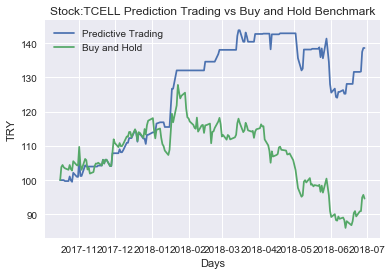

In [130]:
#Telekom - Turkcell
tcell_df_base = get_stock_from_mynet("TCELL",stock_range="yillik_5") # 11.08% in year
predict_stock(tcell_df_base,"TCELL",use_all_features =True)


# TAOSO - Tofas Automotive Industries

http://finans.mynet.com/borsa/ajaxCharts/?type=stock&ticker=TOASO&range=5y
Stock: TOASO
Generating stock features for:  TAOSO - Tofas
DF2 shape before Nan drop: (1243, 24)
DF2 shape (drop 20% nan colmns): (1243, 24)
DF2 shape after dropping na: (1213, 24)
DF2 shape after cleanup: (1212, 24)
original df2 copyied to orig_df2_before_train:
DF2 shape after final drop: (1212, 19)
normalizing train


/Users/gorkemgoknar/Documents/anaconda3/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/gorkemgoknar/Desktop/udacity_capstone/capstone_module.py:369: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_train[column] = normalize_series( X_train[column] )


normalizing test


/Users/gorkemgoknar/Desktop/udacity_capstone/capstone_module.py:375: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Best parameters and best estimator
{'C': 1, 'gamma': 0.1, 'kernel': 'sigmoid', 'shrinking': False}
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=31, shrinking=False,
  tol=0.001, verbose=False)
Predicting Test
Scores:
             precision    recall  f1-score   support

          0       0.60      0.69      0.64       101
          1       0.52      0.42      0.47        81

avg / total       0.56      0.57      0.56       182

F1 Score:  0.5636725973536328
F0.5 Score: 0.5632295025117748
Accuracy Score:  0.5714285714285714
Scores:
             precision    recall  f1-score   support

          0       0.60      0.69      0.64       101
          1       0.52      0.42      0.47        81

avg / total       0.56      0.57      0.56       182

F1 Score:  0.4657534246575342
F0.5 Score: 0.49853372434017595
Accuracy Score:  0.5714285714285714
≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈≈


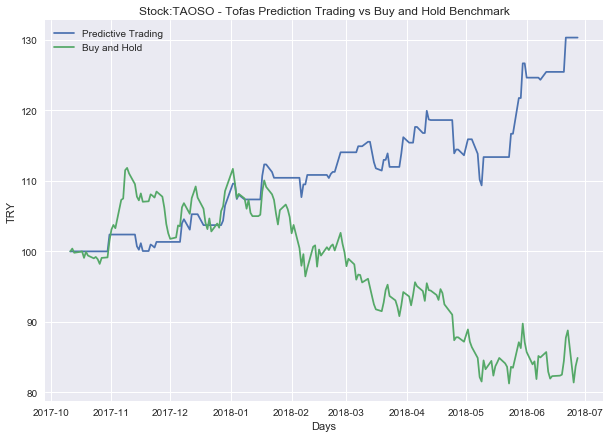

In [70]:
#Only using stock features
toaso_df = get_stock_from_mynet("TOASO",stock_range="yillik_5")
predict_stock(toaso_df,"TAOSO - Tofas")